# Мобильные приложения — Выделение групп пользователей на основе поведения

**Описание данных**

Датасет содержит данные о событиях, совершенных в мобильном приложении **"Ненужные вещи"**. В этом приложении пользователи могут продавать свои ненужные вещи, размещая их на доске объявлений. Данные включают действия пользователей, которые впервые начали использовать приложение после 7 октября 2019 года.

**Колонки в /datasets/mobile_sources.csv:**

- `userId` — идентификатор пользователя;
- `source` — источник, с которого пользователь установил приложение (например, Yandex, Google и т. д.).

**Колонки в /datasets/mobile_dataset.csv:**

- `event.time` — время совершения действия;
- `user.id` — идентификатор пользователя;
- `event.name` — название действия пользователя.

**Виды действий (event.name):**

- `advert_open` — открыл карточки объявления;
- `photos_show` — просмотрел фотографии в объявлении;
- `tips_show` — увидел рекомендованные объявления;
- `tips_click` — кликнул по рекомендованному объявлению;
- `contacts_show` или `show_contacts` — посмотрел номер телефона;
- `contacts_call` — позвонил по номеру из объявления;
- `map` — открыл карту объявлений;
- `search_1` — `search_7` — различные действия, связанные с поиском по сайту (например, поиск по категориям);
- `favorites_add` — добавил объявление в избранное.

---

Для дальнейшего анализа данных мы будем использовать эти столбцы, чтобы сегментировать пользователей, анализировать их поведение и проверять гипотезы.

**Задачи проекта:**
- Выбрать способ сегментации пользователей, аргументировать
- Определить, пользователи какой группы склонны часто возвращаться в мобильное приложение (retention rate)?
- Определить, пользователи какой группы часто делают целевое событие (конверсия в целевое действие)?


**Ход исследования**

* Загрузка и предобработка данных;
* Исследовательский анализ данных;
* Сегментация пользователей;
* Проверка Гипотез;
* Вывод.

## Загрузка и предобработка данных

### Установка библиотек, загрузка данных, проверка их содержимого и структуры.


In [97]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from statsmodels.stats.proportion import proportions_ztest
from matplotlib.colors import LinearSegmentedColormap

In [98]:
mobile_dataset = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_dataset.csv')
mobile_sources = pd.read_csv('https://code.s3.yandex.net/datasets/mobile_sources.csv')

In [99]:
# Задаём функцию для первичного анализа датафреймов
def primary_analysis(df, exclude_columns=[]):
    # Вывод первых 5 строк
    print("Head of the DataFrame:")
    display(df.head())
    
    # Общая информация о DataFrame
    print("Info:")
    df.info()
    
    # Описание числовых столбцов
    numerical_columns = df.select_dtypes(include=['number']
                                        ).columns.difference(exclude_columns)
    
    if not numerical_columns.empty:
        print()
        print("Description of numerical columns:")
        display(df[numerical_columns].describe())

In [100]:
primary_analysis(mobile_dataset)

Head of the DataFrame:


,event.time,event.name,user.id
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
2,2019-10-07 00:00:02.245341,tips_show,cf7eda61-9349-469f-ac27-e5b6f5ec475c
3,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894
4,2019-10-07 00:00:56.319813,advert_open,cf7eda61-9349-469f-ac27-e5b6f5ec475c


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74197 entries, 0 to 74196
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event.time  74197 non-null  object
 1   event.name  74197 non-null  object
 2   user.id     74197 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [101]:
primary_analysis(mobile_sources)

Head of the DataFrame:


,userId,source
0,020292ab-89bc-4156-9acf-68bc2783f894,other
1,cf7eda61-9349-469f-ac27-e5b6f5ec475c,yandex
2,8c356c42-3ba9-4cb6-80b8-3f868d0192c3,yandex
3,d9b06b47-0f36-419b-bbb0-3533e582a6cb,other
4,f32e1e2a-3027-4693-b793-b7b3ff274439,google


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4293 entries, 0 to 4292
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   userId  4293 non-null   object
 1   source  4293 non-null   object
dtypes: object(2)
memory usage: 67.2+ KB


### Объединение датасетов
Объединяем mobile_dataset и mobile_sources


In [102]:
# Переименование колонки для согласованности
mobile_dataset.rename(columns={'user.id': 'userId'}, inplace=True)

# Объединение таблиц
df = pd.merge(mobile_dataset, mobile_sources, on='userId', how='inner')

df.head()

,event.time,event.name,userId,source
0,2019-10-07 00:00:00.431357,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236320,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:07.039334,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
3,2019-10-07 00:01:27.770232,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:01:34.804591,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other


### Замена названий столбцов


In [103]:
# Переименование колонок в snake_case
df.rename(columns={'userId': 'user_id', 'event.time': 'event_time',
                    'event.name': 'event_name'}, inplace=True)

df.columns

Index(['event_time', 'event_name', 'user_id', 'source'], dtype='object')

### Проверка типов данных 

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   event_time  74197 non-null  object
 1   event_name  74197 non-null  object
 2   user_id     74197 non-null  object
 3   source      74197 non-null  object
dtypes: object(4)
memory usage: 2.8+ MB


Все колонки содержат объекты типа object.
- `event_time` стоит преобразовать в тип datetime для удобства анализа времени событий.
- В остальных случаях всё в порядке.

In [105]:
# Перевод даты в  datetime
df['event_time'] = pd.to_datetime(df['event_time'])

# Проверка
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74197 entries, 0 to 74196
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74197 non-null  datetime64[ns]
 1   event_name  74197 non-null  object        
 2   user_id     74197 non-null  object        
 3   source      74197 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.8+ MB


### Проверка на наличие пропущенных значений

In [106]:
# Проверка пропущенных значений по колонкам
print('Количество пропущенных значений')
df.isnull().sum()

Количество пропущенных значений


event_time    0
event_name    0
user_id       0
source        0
dtype: int64

Пропущенных значений нет, что было видно ещё в начале.

### Проверка на наличие явных и неявных дубликатов

In [107]:
print('Количество явных дубликатов:', df.duplicated().sum())

Количество явных дубликатов: 0


Для проверки на неявные дубликаты можно проверить колонку 'event_time', поскольку только в ней данные не должны повторяться.

In [108]:
print('Количество уникальных сессий в event_time:', df['event_time'].nunique())

Количество уникальных сессий в event_time: 74197


Столько же, сколько строк в датасете. Значит, неявных дубликатов тоже нет. Но округлим время событий до милисекунд и проверим дубликаты событий для каждого пользователя.

In [109]:
# Округляем сессии до милисекунд
df['event_time'] = df['event_time'].dt.round('ms')

# Проверка дубликатов event_time для каждого user_id
duplicates = df[df.duplicated(subset=['user_id', 'event_time'], keep=False)]

# Вывод количества и примеров дубликатов
print(f"Количество дубликатов сессий: {len(duplicates)}")
duplicates.head(10)

Количество дубликатов сессий: 94


,event_time,event_name,user_id,source
866,2019-10-08 13:18:43.941,tips_show,1e073228-bb96-4da0-adf8-87472e4247bf,google
867,2019-10-08 13:18:43.941,advert_open,1e073228-bb96-4da0-adf8-87472e4247bf,google
1222,2019-10-08 13:14:51.596,map,ed13f6f0-08f4-4561-852e-456580f7a40d,yandex
1223,2019-10-08 13:14:51.596,map,ed13f6f0-08f4-4561-852e-456580f7a40d,yandex
1581,2019-10-21 12:36:51.478,tips_show,cb36854f-570a-41f4-baa8-36680b396370,yandex
1582,2019-10-21 12:36:51.478,contacts_show,cb36854f-570a-41f4-baa8-36680b396370,yandex
2133,2019-10-07 14:37:35.946,advert_open,2c669a3c-dcd4-4c8a-8f06-3a01cc96bb8e,yandex
2134,2019-10-07 14:37:35.946,advert_open,2c669a3c-dcd4-4c8a-8f06-3a01cc96bb8e,yandex
2835,2019-10-16 10:27:50.101,contacts_show,9b835c74-8ede-4586-9f59-e5473aa48de2,other
2836,2019-10-16 10:27:50.101,contacts_show,9b835c74-8ede-4586-9f59-e5473aa48de2,other


Видно, что часть событий - это действительно дубликаты (одно и то же событие в ту же самую милисекунду), а часть - разные событияв одну и ту же милисекунду. Так как в целом дубликатов мало (меньше 100), я решаю их просто удалить.

In [110]:
# Удаление дубликатов на основе user_id и event_time
df = df.drop_duplicates(subset=['user_id', 'event_time'], keep='first').reset_index(drop=True)

# Проверка результата
print(f"Количество строк после удаления дубликатов: {len(df)}")
df.head()

Количество строк после удаления дубликатов: 74150


,event_time,event_name,user_id,source
0,2019-10-07 00:00:00.431,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:07.039,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
3,2019-10-07 00:01:27.770,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:01:34.805,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other


### Преобразование данных

В датасете есть одинаковые виды событий, записанные по разному: `contacts_show` или `show_contacts`. Надо назвать их одинаково. 

Также есть `search_1` — `search_7` — различные действия, связанные с поиском по сайту. Более подробной информации по поиску нет, поэтому объединим их в единое событие `search`.



In [111]:
# Объединение одинаковых событий как 'show_contacts'
df['event_name'] = df['event_name'].replace({'contacts_show': 'show_contacts'})

In [112]:
# Замена search_1 - search_7 на 'search'
df['event_name'] = df['event_name'].replace({
    'search_1': 'search', 'search_2': 'search', 'search_3': 'search',
    'search_4': 'search', 'search_5': 'search', 'search_6': 'search',
    'search_7': 'search'
})

# Проверка уникальных событий в колонке 'event_name'
df['event_name'].unique()

array(['advert_open', 'tips_show', 'map', 'tips_click', 'search',
       'show_contacts', 'photos_show', 'favorites_add', 'contacts_call'],
      dtype=object)

### Вывод

• **Названия столбцов** приведены к snake_case;

• **Типы данных**  Столбец `event_time` преобразован в тип datetime. Остальные колонки имеют тип object.

• **Пропуски** не обнаружены. 

• **Дубликаты** Проверка показала отсутствие явных дубликатов, однако выявлено 94 неявных дубликата (события в одно и то же время для одного пользователя), которые были удалены, уменьшив размер датасета с 74197 до 74150 строк.

• **Преобразование данных** Проведено объединение дублирующихся событий: `contacts_show` и `show_contacts` приведены к `show_contacts`, а события `search_1` — `search_7` объединены в `search`.

## Исследовательский анализ данных


### Общие характеристики:

#### Подсчитать общее количество пользователей, событий и уникальных действий.

In [113]:
primary_analysis(df)

Head of the DataFrame:


,event_time,event_name,user_id,source
0,2019-10-07 00:00:00.431,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
1,2019-10-07 00:00:01.236,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
2,2019-10-07 00:00:07.039,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other
3,2019-10-07 00:01:27.770,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other
4,2019-10-07 00:01:34.805,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74150 entries, 0 to 74149
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   event_time  74150 non-null  datetime64[ns]
 1   event_name  74150 non-null  object        
 2   user_id     74150 non-null  object        
 3   source      74150 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.3+ MB


В объединенном DataFrame 74 150 строк и 4 столбца: event_time (datetime), event_name, user_id и source (объекты). Все столбцы полностью заполнены, без пропусков, и объём данных — около 2,3 МБ.

In [114]:
print('Событий в логе:', df['event_name'].value_counts().sum()) 
print('Уникальных пользователей:', df['user_id'].nunique())

Событий в логе: 74150
Уникальных пользователей: 4293


In [115]:
print('Количество действий для каждого вида событий:')
event_counts = df['event_name'].value_counts()
event_counts.to_frame()

Количество действий для каждого вида событий:


,event_name
tips_show,40052
photos_show,9997
search,6783
advert_open,6160
show_contacts,4514
map,3873
favorites_add,1417
tips_click,813
contacts_call,541


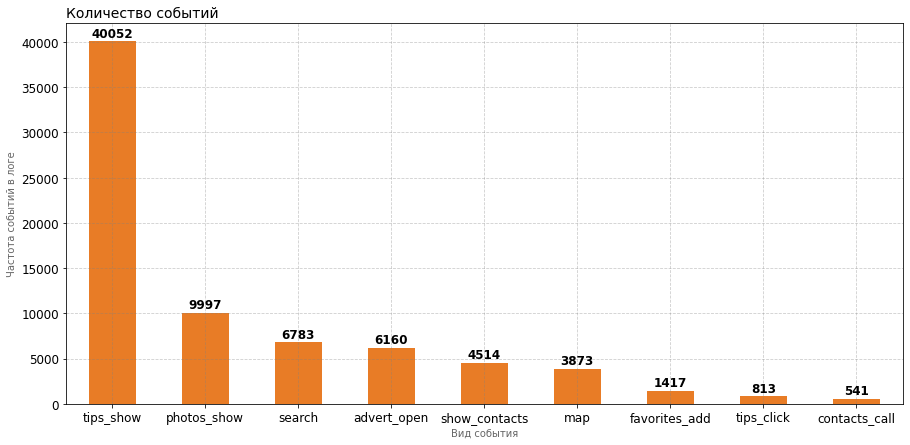

In [116]:
ax = event_counts.plot(kind='bar', figsize=(15, 7), rot=0,
                       legend=False, fontsize=12, color='#E87C26')
plt.title('Количество событий', fontsize=14, loc='left')
plt.xlabel('Вид события', alpha=0.6)
plt.ylabel('Частота событий в логе', alpha=0.6)
plt.grid(True, which='major', axis='both', linestyle='--', color='gray', alpha=0.4)

# Добавляем цифры над столбиками
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2,  # Центр столбца
            i.get_height() + 200,           # Немного выше верхушки столбца
            str(int(i.get_height())),       # Значение, которое будет показано
            ha='center', va='bottom',       # Центрируем текст по горизонтали, выравниваем по нижнему краю
            fontsize=12, color='black', weight='bold')  # Настраиваем размер и цвет шрифта (черный для контраста)

plt.show()


Основное событие — `tips_show` с наибольшим количеством действий (40 052), следом идут `photos_show` (9 997) и `search` (6 783). Самые редкие события — `tips_click` (813) и `contacts_call` (541).

Считаем, сколько пользователей совершали каждое из этих событий. Отсортируем события по числу пользователей.

In [117]:
user_counts = df.groupby('event_name').agg({'user_id': 'nunique'}
                                          ).sort_values(by='user_id', ascending=False)
user_counts

,user_id
event_name,
tips_show,2801
search,1666
map,1456
photos_show,1095
show_contacts,981
advert_open,751
favorites_add,351
tips_click,322
contacts_call,213


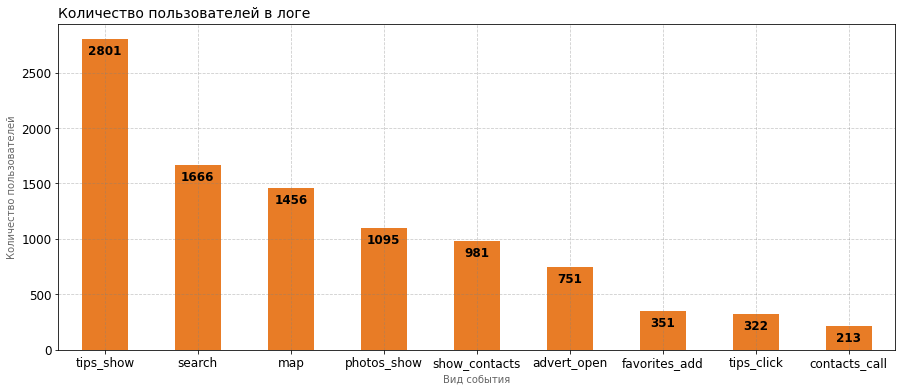

In [118]:
bx = user_counts['user_id'].plot(kind='bar', figsize=(15, 6), rot=0, 
                                 legend=False, fontsize=12, color='#E87C26')

plt.title('Количество пользователей в логе', fontsize = 14, loc='Left')
plt.xlabel('Вид события', alpha=0.6)
plt.ylabel('Количество пользователей', alpha=0.6)
plt.grid(True, which='major', axis='both', linestyle='--', color='gray', alpha=0.4)

# Добавляем цифры внутри столбиков
for i in bx.patches:
    bx.text(i.get_x() + i.get_width() / 2,  # Центр столбца
            i.get_height() - 50,           # Располагаем текст внутри столбца, немного ниже верхушки
            str(int(i.get_height())),       # Значение, которое будет показано
            ha='center', va='top',          # Центрируем текст по горизонтали, выравниваем по верхушке
            fontsize=12, color='black', weight='bold')     # Настраиваем размер и цвет шрифта (белый для контраста)


plt.show()

Наибольшее число пользователей наблюдается для события `tips_show` — 2801. Далее идут `search` (1666), `map` (1456), `photos_show` (1095) и `show_contacts` (981). События с наименьшим числом пользователей: `advert_open` (751), `favorites_add` (351), `tips_click` (322) и `contacts_call` (213).

#### Выявить распределение событий по времени (event_time).

In [119]:
# Определяем минимальную и максимальную даты событиq
print('Дата первого события:', df['event_time'].min())
print('Дата последнего события:', df['event_time'].max())

Дата первого события: 2019-10-07 00:00:00.431000
Дата последнего события: 2019-11-03 23:58:12.532000


Данные охватывают период с 7 октября 2019 года до 3 ноября 2019 года, что составляет чуть менее месяца.

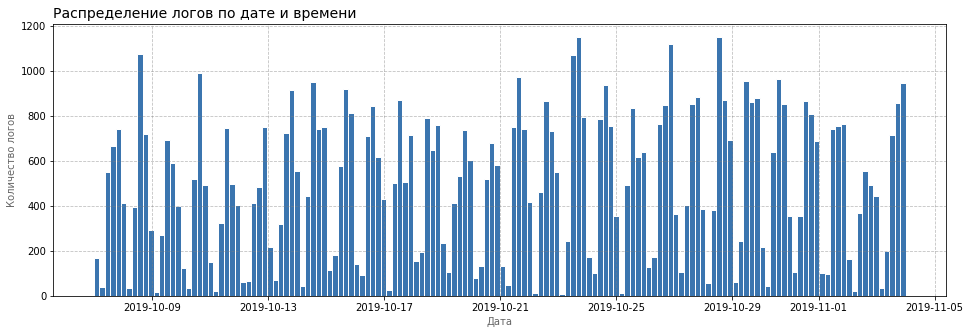

In [120]:
# как меняется количество данных
df['event_time'].hist(bins=150, figsize=(16, 5), color='#3b75af',
                              edgecolor='white')
plt.title('Распределение логов по дате и времени', fontsize = 14, loc='Left')
plt.xlabel('Дата', alpha=0.6)
plt.ylabel('Количество логов', alpha=0.6)
plt.grid(True, which='major', axis='both', linestyle='--', color='gray', alpha=0.5)
plt.show()

Активность пользователей варьируется, с пиками около 1000 логов в день. В середине и конце периода наблюдаются относительно более высокие значения.

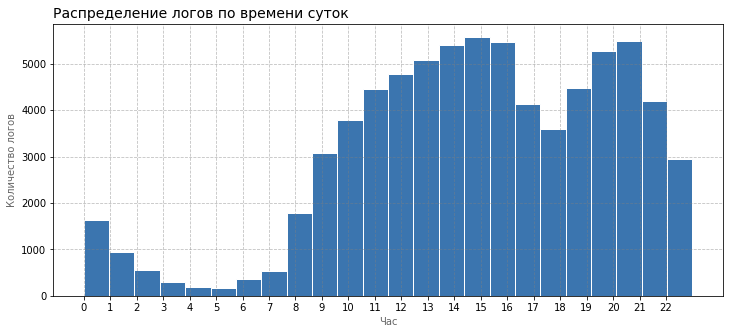

In [121]:
df['event_time'].dt.hour.hist(bins=24, figsize=(12, 5), color='#3b75af',
                                     edgecolor='white')
plt.title('Распределение логов по времени суток', fontsize = 14, loc='Left')
plt.xlabel('Час', alpha=0.6)
plt.ylabel('Количество логов', alpha=0.6)
plt.xticks(range(0, 23))
plt.grid(True, which='major', axis='both', linestyle='--', color='gray', alpha=0.5)
plt.show()

Наибольшая активность пользователей наблюдается с 12:00 до 21:00, достигая пика около 15:00. Есть также просадка между 16 и 19 часами. Минимум активности приходится на ночное время (с 2:00 до 6:00).

### Анализ метрик:

#### Retention rate:

- Определить дату первого события для каждого пользователя. 
- Создать когорты (по дням либо по неделям).
- Рассчитать Retention Rate.
- Построить таблицу Retention.
- Визуализировать результаты (тепловая карта).


In [122]:
# Определим дату первого события для каждого пользователя
first_event = df.groupby('user_id')['event_time'].min().reset_index()
first_event.columns = ['user_id', 'first_event']

# Соединяем таблицы по user_id
df = df.merge(first_event, on='user_id', how='left')

In [123]:
# Создаём когорты (по неделям)
#df['cohort'] = df['first_event'].dt.to_period('W').dt.start_time

# Создаём когорты (по дням)
df['cohort'] = df['first_event'].dt.date
df

,event_time,event_name,user_id,source,first_event,cohort
0,2019-10-07 00:00:00.431,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00.431,2019-10-07
1,2019-10-07 00:00:01.236,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00.431,2019-10-07
2,2019-10-07 00:00:07.039,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00.431,2019-10-07
3,2019-10-07 00:01:27.770,advert_open,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00.431,2019-10-07
4,2019-10-07 00:01:34.805,tips_show,020292ab-89bc-4156-9acf-68bc2783f894,other,2019-10-07 00:00:00.431,2019-10-07
...,...,...,...,...,...,...
74145,2019-11-03 23:46:47.068,map,d157bffc-264d-4464-8220-1cc0c42f43a9,google,2019-11-03 23:46:47.068,2019-11-03
74146,2019-11-03 23:46:58.915,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,google,2019-11-03 23:46:47.068,2019-11-03
74147,2019-11-03 23:47:01.232,tips_show,d157bffc-264d-4464-8220-1cc0c42f43a9,google,2019-11-03 23:46:47.068,2019-11-03
74148,2019-11-03 23:47:47.475,advert_open,d157bffc-264d-4464-8220-1cc0c42f43a9,google,2019-11-03 23:46:47.068,2019-11-03


In [124]:
# Задаём функцию для расчёта удержания
def calculate_retention(df):
    """
    Рассчитывает Retention Rate по данным о сессиях пользователей.
    
    Параметры:
    df - DataFrame с колонками:
        - cohort: дата первого события пользователя (когорта)
        - event_time: время события
        - first_event: время первого события пользователя
        - user_id: идентификатор пользователя

    Возвращает:
    retention_pivot - сводная таблица удержания по когортам и дням жизни
    """
    # Создаем колонку с днем жизни пользователя
    df['days_since_first_event'] = (df['event_time'] - df['first_event']).dt.days

    # Группируем по когортам и дням жизни
    retention = (
        df.groupby(['cohort', 'days_since_first_event'])
        .agg(users=('user_id', 'nunique'))
        .reset_index()
    )

    # Рассчитываем размеры когорт
    cohort_sizes = (
        retention[retention['days_since_first_event'] == 0]
        [['cohort', 'users']]
        .rename(columns={'users': 'cohort_size'})
    )

    # Объединяем с основными данными
    retention = retention.merge(cohort_sizes, on='cohort')

    # Рассчитываем Retention Rate
    retention['retention_rate'] = retention['users'] / retention['cohort_size']

    # Преобразуем в сводную таблицу
    retention_pivot = retention.pivot(
        index='cohort', 
        columns='days_since_first_event', 
        values='retention_rate'
    )
    
    return retention_pivot

In [125]:
# Применяем
retention_pivot = calculate_retention(df)
retention_pivot

days_since_first_event,0,1,2,3,4,5,6,7,8,9,...,17,18,19,20,21,22,23,24,25,26
cohort,,,,,,,,,,,,,,,,,,,,,
2019-10-07,1.0,0.122549,0.098039,0.107843,0.053922,0.039216,0.058824,0.078431,0.053922,0.049020,...,0.019608,0.044118,0.024510,0.014706,0.019608,0.034314,0.034314,0.039216,0.044118,0.029412
2019-10-08,1.0,0.161677,0.125749,0.053892,0.041916,0.065868,0.053892,0.071856,0.059880,0.041916,...,0.029940,0.017964,0.047904,0.035928,0.017964,0.023952,0.041916,0.029940,0.023952,0.011976
2019-10-09,1.0,0.073864,0.062500,0.056818,0.068182,0.068182,0.056818,0.073864,0.062500,0.034091,...,0.017045,0.011364,0.028409,0.011364,0.034091,0.011364,0.005682,0.022727,0.017045,NaN
2019-10-10,1.0,0.091954,0.103448,0.080460,0.097701,0.080460,0.068966,0.051724,0.080460,0.034483,...,0.063218,0.034483,0.028736,0.017241,0.040230,0.017241,0.011494,0.011494,NaN,NaN
2019-10-11,1.0,0.088235,0.117647,0.095588,0.088235,0.073529,0.073529,0.044118,0.014706,0.044118,...,0.058824,0.029412,0.022059,0.022059,0.029412,0.029412,0.014706,NaN,NaN,NaN
2019-10-12,1.0,0.128000,0.160000,0.056000,0.064000,0.088000,0.080000,0.088000,0.080000,0.064000,...,0.040000,0.040000,0.024000,0.024000,0.064000,0.032000,NaN,NaN,NaN,NaN
2019-10-13,1.0,0.128378,0.067568,0.054054,0.067568,0.054054,0.054054,0.047297,0.047297,0.047297,...,0.013514,0.020270,0.013514,0.033784,0.006757,NaN,NaN,NaN,NaN,NaN
2019-10-14,1.0,0.113514,0.102703,0.102703,0.081081,0.070270,0.054054,0.043243,0.075676,0.037838,...,0.037838,0.021622,0.016216,0.005405,NaN,NaN,NaN,NaN,NaN,NaN
2019-10-15,1.0,0.139785,0.091398,0.080645,0.053763,0.053763,0.080645,0.075269,0.064516,0.021505,...,0.032258,0.026882,0.016129,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
# Функция для визуализации удержания
def plot_retention_heatmap(retention_pivot, exclude_first_day=True, horizon_days=None, title='Тепловая карта удержания'):
    """
    Строит тепловую карту удержания по данным retention_pivot.

    Параметры:
    retention_pivot : DataFrame
        Сводная таблица с когортами (index) и днями жизни (columns).
    exclude_first_day : bool, optional (default=True)
        Исключать ли первый день (нулевой лайфтайм) из графика.
    horizon_days : int, optional
        Горизонт анализа по дням жизни. Если None, используются все доступные данные.
    title : str, optional (default='Тепловая карта удержания')
        Заголовок графика.
    """

        # Создаём кастомную цветовую палитру
    custom_cmap = LinearSegmentedColormap.from_list(
        'custom_cmap', ['#4A90E2', '#D3D3D3', '#E87C26'], N=256
    )
    
    plt.figure(figsize=(22, 9))
    
    # Удаляем нулевой лайфтайм, если exclude_first_day = True
    if exclude_first_day:
        retention_pivot = retention_pivot.drop(columns=[0], errors='ignore')
    
    # Применяем горизонт анализа, если задан horizon_days
    if horizon_days:
        retention_pivot = retention_pivot.iloc[:, :horizon_days]

    sns.heatmap(
        retention_pivot,  # данные для тепловой карты
        annot=True,       # подписи на графике
        fmt='.2%',        # формат подписей (проценты)
        cmap=custom_cmap,   # цветовая схема
        linewidths=0.5    # разделение линиями между ячейками
    )
    
    plt.title(title, loc='left')  # Название графика
    plt.xlabel('Lifetime (days)')  # Подпись оси X
    plt.ylabel('Cohort (start date)')  # Подпись оси Y
    plt.show()

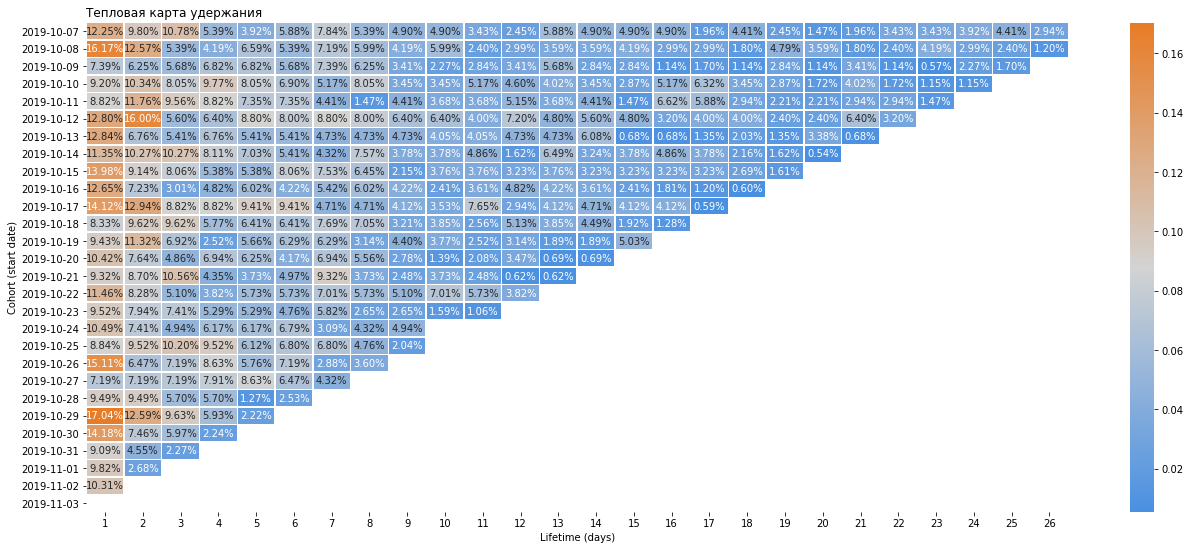

In [127]:
# строим хитмэп без нулевого лайфтайма
plot_retention_heatmap(retention_pivot)

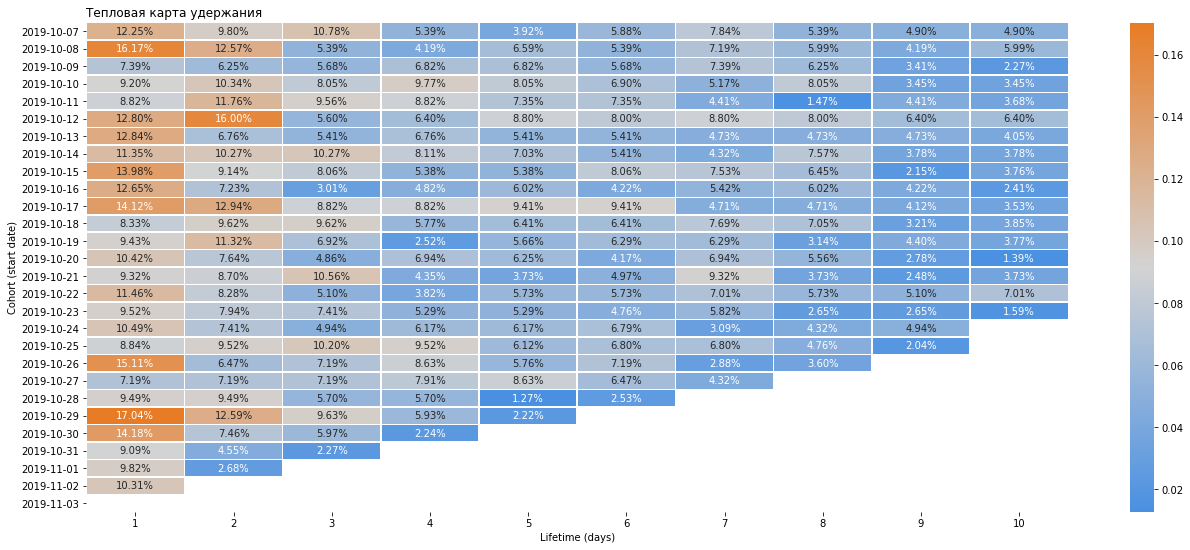

In [128]:
# Хитмэп с горизонтом анализа в 10 дней
plot_retention_heatmap(retention_pivot, horizon_days=10)


- На 2ой день возвращаются только 12–16%, после этого оно падает до 5–8% к 5-му дню.


- Некоторые когорты демонстрируют более высокое начальное (когорты 2019-10-08 с 16.2% и 2019-10-29 с 17% на 1-й день) или более длительное (когорта 2019-10-12 и  с 16.2% на 1-й день) удержание  по сравнению с другими. Это может быть связано с разными маркетинговыми кампаниями, источниками привлечения пользователей или иными факторами, влияющими на поведение.


- После 7–8 дней удержание стабилизируется на уровне около 2–4%. Это указывает на то, что большинство пользователей либо прекращают использовать приложение, либо делают это нерегулярно.


- В некоторых когортных днях наблюдаются аномалии, например, увеличение удержания на более поздних этапах (например, когорта 2019-10-26 на 7-й день с 8.6%). Это может быть связано с повторной активацией пользователей через напоминания, акции или изменения в приложении.

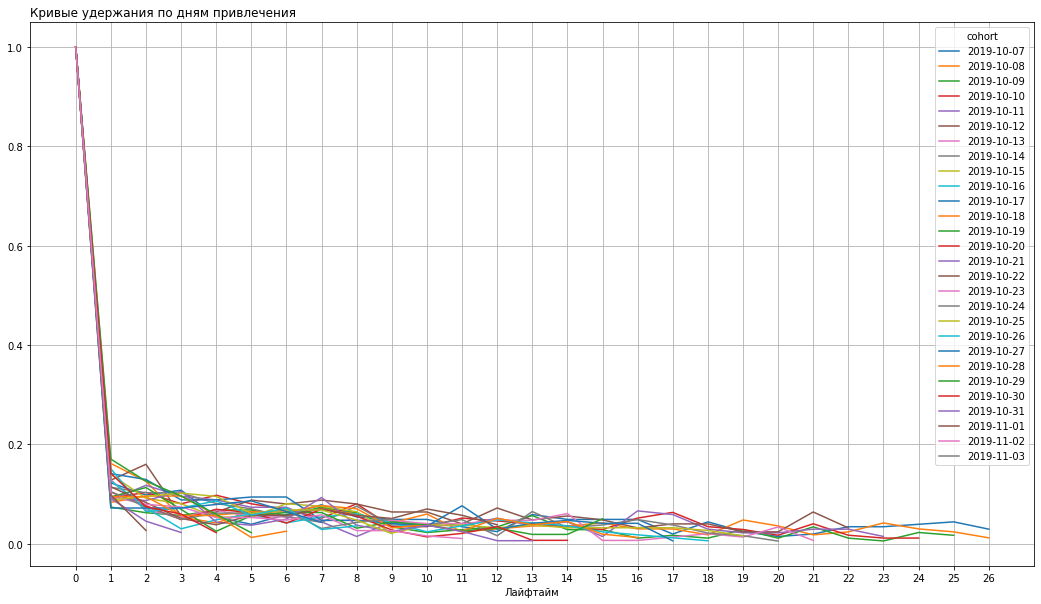

In [129]:
# строим кривые удержания
retention_pivot.T.plot(
    grid=True,  # добавляем сетку
    xticks=list(retention_pivot.columns.values),  # отметки на оси X — названия колонок
    figsize=(18, 10),  # размер графика
)
plt.xlabel('Лайфтайм')  # название оси X
plt.title('Кривые удержания по дням привлечения', loc='left') 
plt.show()

Удержание пользователей стремительно снижается в первый день, затем снижается более плавно. Некоторые когорты показывают временные всплески удержания, возможно, связанные с акциями или напоминаниями. Поведение пользователей разных когорт схоже на поздних этапах.

Посмотрим, как менялось удержание от когорты к когорте для каждого дня «жизни» пользователей

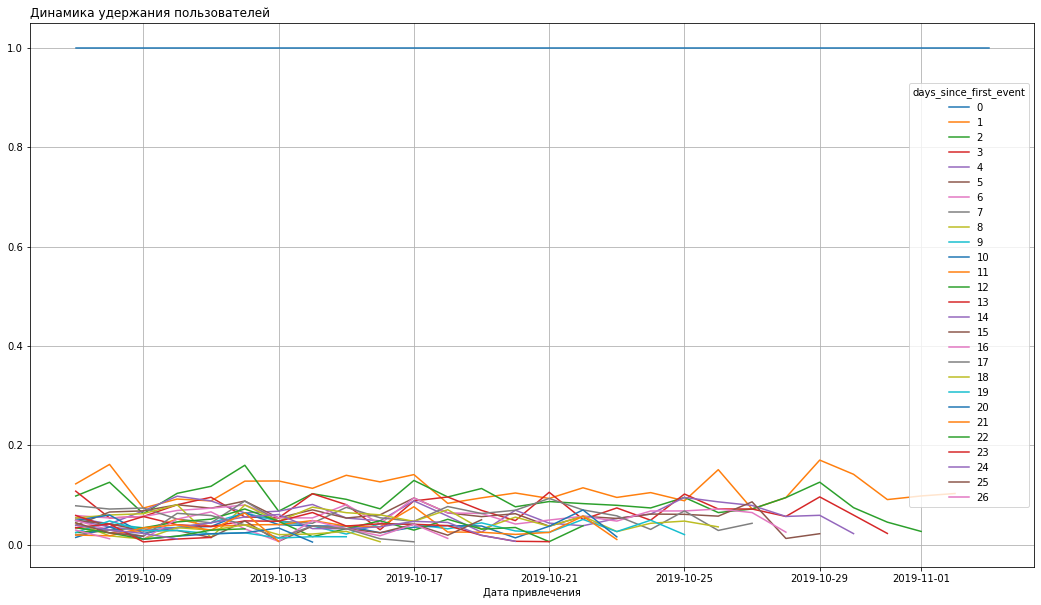

In [130]:
# строим графики изменений
retention_pivot.plot(grid=True, figsize=(18, 10))
plt.xlabel('Дата привлечения')
plt.title('Динамика удержания пользователей', loc='left')
plt.show()

График показывает огромную разницу между первым днем и остальными. Колебания удержания заметны для некоторых дней, что может быть связано с активностями или внешними факторами. После 5-го дня удержание становится более стабильным на низком уровне.


**Вывод:**

Общий тренд: удержание стремительно падает (после первого дня использования после первого дня возращаются только 12–16%) и остаётся низким и стабильным в дальнейшем. 

#### Время, проведённое в приложении:
##### Разделить события пользователя на сессии (по 30 минут).

Почему 30 минут – хороший выбор для этого приложения:

30 минут – стандартное решение, подходящее для большинства пользователей, особенно при поиске товаров. Поведение пользователей здесь похоже на e-commerce платформы, где сессии разделяются по аналогии: поиск – контакт с продавцом (покупка) – выход из приложения. Если пользователь неактивен в течение 30 минут, это, скорее всего, означает, что он закончил поиск или отвлёкся.

Если пользователь решит вернуться в приложение позже, это уже новая сессия поиска и сравнения. Тайм-аут 30 минут позволяет избежать объединения несвязанных периодов активности.

In [131]:
# Сортируем датафрейм по user_id и времени
df = df.sort_values(['user_id', 'event_time'])

# Группируем по user_id и вычисляем разницу во времени с предыдущим событием
df['diff_prev'] = (
    df
    .groupby('user_id')['event_time']
    .diff()
    .dt.total_seconds()
    .div(60)  # переходим из секунд в минуты
)

# Определяем тайм-аут
time_out = 30

# Флаг новой сессии: либо diff_prev == NaN (первое событие в группе),
# либо diff_prev > 20 минут
new_session = (df['diff_prev'].isna()) | (df['diff_prev'] > time_out)

# Создаём столбец session_id, который разделяет события на сессии
df['session_id'] = new_session.cumsum()

##### Посчитаем сессии каждого пользователя

In [132]:
# Посчитаем сессии каждого пользователя
sessions_per_user = (
    df
    .groupby('user_id')['session_id']
    .nunique()  # считаем уникальное количество сессий
    .reset_index(name='sessions_count')
)

sessions_per_user

,user_id,sessions_count
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4
1,00157779-810c-4498-9e05-a1e9e3cedf93,6
2,00463033-5717-4bf1-91b4-09183923b9df,1
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,6
4,00551e79-152e-4441-9cf7-565d7eb04090,3
...,...,...
4288,ffab8d8a-30bb-424a-a3ab-0b63ebbf7b07,2
4289,ffc01466-fdb1-4460-ae94-e800f52eb136,1
4290,ffcf50d9-293c-4254-8243-4890b030b238,1
4291,ffe68f10-e48e-470e-be9b-eeb93128ff1a,3


In [133]:
# Добавляем таблицу пользователей по user_id (на будущее пригодится)
df = df.merge(sessions_per_user, on='user_id', how='left')

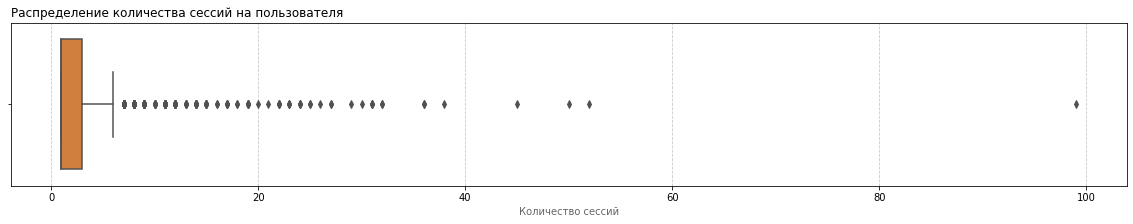

In [134]:
# Строим boxplot
plt.figure(figsize=(20, 3))
sns.boxplot(data=sessions_per_user, x='sessions_count', color='#E87C26')
plt.title('Распределение количества сессий на пользователя', loc='left')
plt.xlabel('Количество сессий', alpha=0.6)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

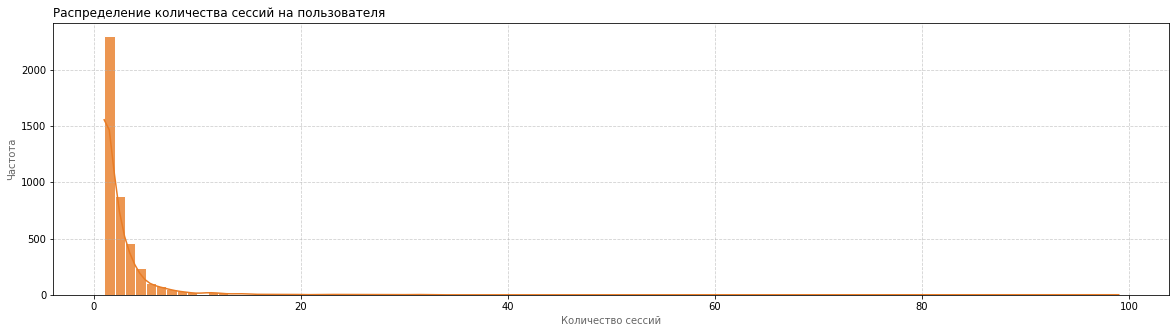

In [135]:
# Гистограмма
plt.figure(figsize=(20, 5))
sns.histplot(data=sessions_per_user, x='sessions_count', kde=True, color='#E87C26',
             binwidth=1, bins=100, alpha=0.8, edgecolor='white')
plt.title('Распределение количества сессий на пользователя', loc='left')
plt.xlabel('Количество сессий', alpha=0.6)
plt.ylabel('Частота', alpha=0.6)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

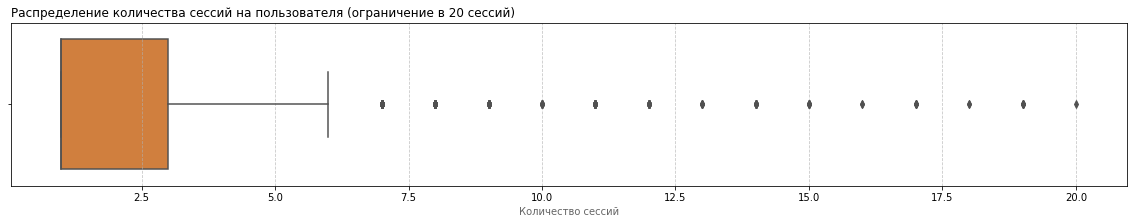

In [136]:
# Ограничиваем число сессий на пользователя цифрой 20
sessions_per_user_limited = sessions_per_user[sessions_per_user['sessions_count'] <= 20]

# Строим boxplot
plt.figure(figsize=(20, 3))
sns.boxplot(data=sessions_per_user_limited, x='sessions_count', color='#E87C26')
plt.title('Распределение количества сессий на пользователя (ограничение в 20 сессий)', loc='left')
plt.xlabel('Количество сессий', alpha=0.6)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

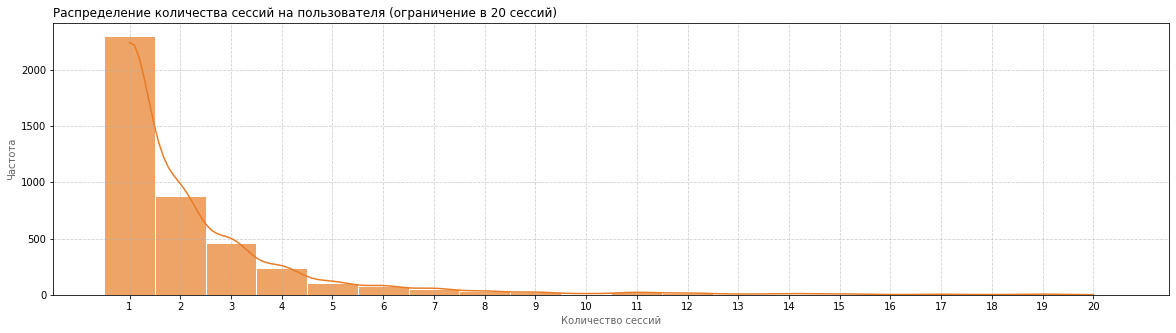

In [137]:
# Гистограмма
plt.figure(figsize=(20, 5))
bins = np.arange(0.5, 20.6, 1)

sns.histplot(
    data=sessions_per_user_limited, 
    x='sessions_count', 
    bins=bins, 
    kde=True,
    edgecolor='white', 
    color='#E87C26',
    alpha=0.7
)

plt.xticks(range(1, 21))

plt.title('Распределение количества сессий на пользователя (ограничение в 20 сессий)', loc='left')
plt.xlabel('Количество сессий', alpha=0.6)
plt.ylabel('Частота', alpha=0.6)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


In [138]:
# Распределение количества сессий
sessions_per_user['sessions_count'].describe().to_frame()

,sessions_count
count,4293.000000
mean,2.415094
std,3.536466
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,99.000000


In [139]:
# Сколько пользователей имели только одну сессию
print(f'Пользователей с 1 сессией: {sessions_per_user[sessions_per_user["sessions_count"] == 1].shape[0]}')

Пользователей с 1 сессией: 2300


**Вывод**:

- Большинство пользователей (около 53%) совершают только одну сессию.


- Медиана также равна 1, а верхний квартиль — 3. Большая часть выборки укладывается в диапазон от 1 до 3 сессий.


- Максимальное значение (99 сессий) и несколько других высоких показателей указывают на наличие «суперактивных» пользователей, формирующих длинный «хвост» распределения.


- По гистограмме видно, что пик (наибольшее количество пользователей) находится у 1–2 сессий, а затем количество пользователей быстро убывает.


- Всё, что выше 5–7 сессий, является достаточно редким явлением.


- Таким образом, распределение числа сессий на пользователя сильно смещено вправо: большинство пользователей выполняет лишь небольшое количество сессий, единичные пользователи проявляют очень высокую активность.

##### Посчитать время для каждой сессии.

In [140]:
# Группируем по пользователю и сессии и берём минимальное/максимальное время
session_times = (
    df
    .groupby(['user_id', 'session_id'], as_index=False)
    .agg(session_start=('event_time', 'min'),
         session_end=('event_time', 'max'))
)

# Считаем разницу между session_end и session_start
session_times['session_duration'] = (
    session_times['session_end'] - session_times['session_start']
).dt.total_seconds() / 60 

session_times.head()


,user_id,session_id,session_start,session_end,session_duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,1,2019-10-07 13:39:45.989,2019-10-07 13:49:41.717,9.928800
1,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,2,2019-10-09 18:33:55.578,2019-10-09 18:42:22.964,8.456433
2,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,3,2019-10-21 19:52:30.779,2019-10-21 20:07:30.051,14.987867
3,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,4,2019-10-22 11:18:14.635,2019-10-22 11:30:52.807,12.636200
4,00157779-810c-4498-9e05-a1e9e3cedf93,5,2019-10-19 21:34:33.850,2019-10-19 21:59:54.637,25.346450


##### Изучить распределение времени сессий 

In [141]:
# Распределение длительностей сессий
session_times['session_duration'].describe().to_frame()

,session_duration
count,10368.000000
mean,12.877877
std,19.860189
min,0.000000
25%,0.352287
50%,5.586167
75%,17.423192
max,321.971600


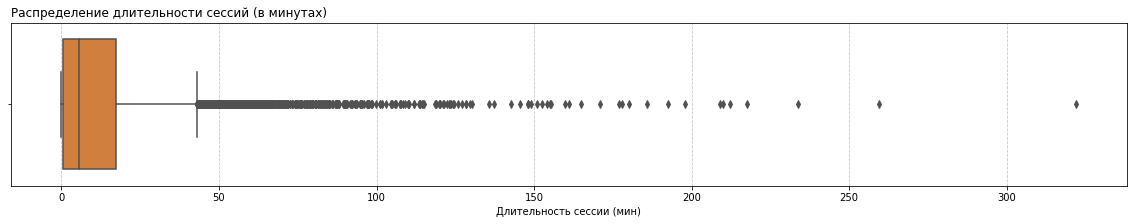

In [142]:
# Строим boxplot
plt.figure(figsize=(20, 3))
sns.boxplot(data=session_times, x='session_duration', color='#E87C26')
plt.title('Распределение длительности сессий (в минутах)', loc='left')
plt.xlabel('Длительность сессии (мин)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

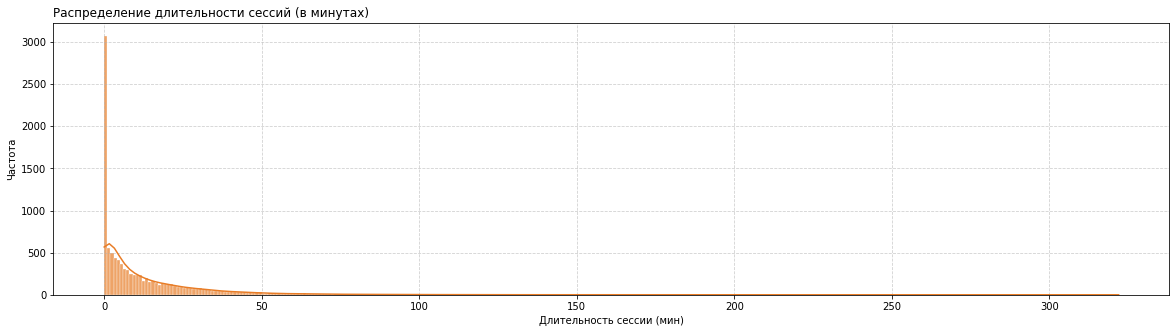

In [143]:
# Гистограмма длительности сессий
plt.figure(figsize=(20, 5))
sns.histplot(data=session_times, x='session_duration', kde=True, alpha=0.7,
             binwidth=1, bins=100, color='#E87C26', edgecolor='white')
plt.title('Распределение длительности сессий (в минутах)', loc='left')
plt.xlabel('Длительность сессии (мин)')
plt.ylabel('Частота')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

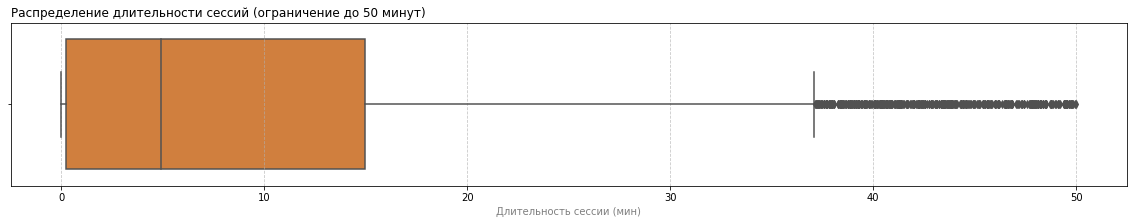

In [144]:
# Фильтруем сессии, длительность которых <= 50 минут
filtered_sessions = session_times[session_times['session_duration'] <= 50]

# Boxplot (ящик с усами) для ограниченных сессий
plt.figure(figsize=(20, 3))
sns.boxplot(data=filtered_sessions, x='session_duration', color='#E87C26')
plt.title('Распределение длительности сессий (ограничение до 50 минут)', loc='left')
plt.xlabel('Длительность сессии (мин)', alpha=0.5)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

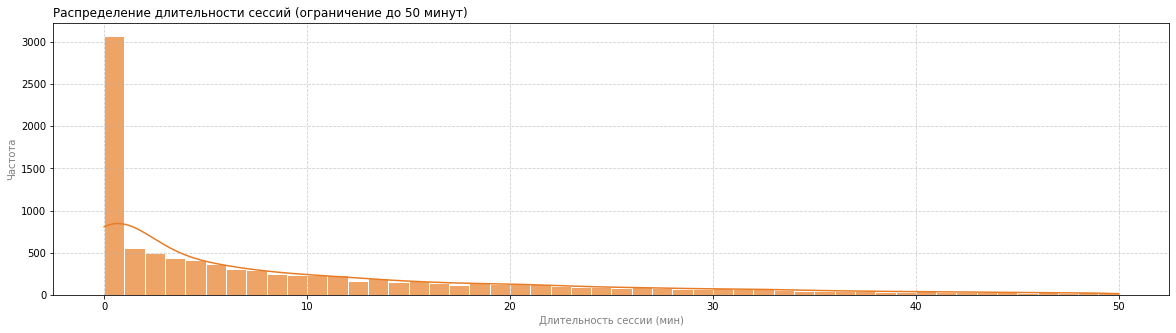

In [145]:
# Гистограмма
plt.figure(figsize=(20, 5))
sns.histplot(data=filtered_sessions, x='session_duration', kde=True,
             alpha=0.7, binwidth=1, bins=50, color='#E87C26', edgecolor='white')
plt.title('Распределение длительности сессий (ограничение до 50 минут)', loc='left')
plt.xlabel('Длительность сессии (мин)', alpha=0.5)
plt.ylabel('Частота', alpha=0.5)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [146]:
# Изучение аномально коротких и длинных сессий

# Посмотрим сессии с нулевой длительностью:
print(
    f'Сессии с нулевой длительностью: '
    f'{session_times.query("session_duration == 0").shape[0]}'
)

# Анализ очень коротких сессий (менее 1 минуты)
print(
    f'Сессии менее 1 минуты: '
    f'{session_times[session_times["session_duration"] < 1].shape[0]}'
)

# Анализ длинных сессий (выше 95-го перцентиля)
long_threshold = session_times['session_duration'].quantile(0.95)
print(
    f'Длинные сессии (дольше {long_threshold:.2f} минут): '
    f'{session_times[session_times["session_duration"] > long_threshold].shape[0]}'
)

Сессии с нулевой длительностью: 2089
Сессии менее 1 минуты: 3072
Длинные сессии (дольше 48.52 минут): 519


**Вывод:**  

- **Общее количество сессий**: 10 368. Средняя длительность сессии: **12.88 минут**. Медиана: **5.59 минут**. 75% сессий укладываются в **17.42 минуты**. Максимальная длительность сессии: **321.97 минут**. Стандартное отклонение: **19.86 минут** — значительный разброс, что говорит о наличии выбросов и длинных сессий.  


- **Много коротких сессий и выбросы в виде долгих сессий**. **2089 сессий (20%)** с нулевой длительностью — возможно, быстрый выход или сбой логов. **3072 сессии (30%)** короче 1 минуты — низкая вовлечённость или тесты. Для более детального анализа стоит рассмотреть причины нулевых сессий и исключить их из дальнейших расчётов. 


- Ключевая точка оттока пользователей — первая сессия. Решение проблемы низкой вовлечённости требует оптимизации пользовательского пути, анализа технических ошибок и дополнительной работы с обратной связью от пользователей, покидающих приложение слишком быстро.


- **519 сессий (5%)** длиннее **48.52 минут** — вероятные выбросы или забытые вкладки. Длинные сессии (дольше 50 минут) можно рассматривать отдельно как аномалии.

 ##### Распределение времени сессий для пользователей с одной сессией

In [147]:
# Присоединяем session_start, session_end и session_duration к df
df = df.merge(
    session_times[['user_id', 'session_id', 'session_start', 'session_end', 'session_duration']], 
    on=['user_id', 'session_id'], 
    how='left'
)

# Проверяем результат
df.head()

,event_time,event_name,user_id,source,first_event,cohort,days_since_first_event,diff_prev,session_id,sessions_count,session_start,session_end,session_duration
0,2019-10-07 13:39:45.989,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:45.989,2019-10-07,0,NaN,1,4,2019-10-07 13:39:45.989,2019-10-07 13:49:41.717,9.9288
1,2019-10-07 13:40:31.053,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:45.989,2019-10-07,0,0.751067,1,4,2019-10-07 13:39:45.989,2019-10-07 13:49:41.717,9.9288
2,2019-10-07 13:41:05.722,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:45.989,2019-10-07,0,0.577817,1,4,2019-10-07 13:39:45.989,2019-10-07 13:49:41.717,9.9288
3,2019-10-07 13:43:20.735,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:45.989,2019-10-07,0,2.250217,1,4,2019-10-07 13:39:45.989,2019-10-07 13:49:41.717,9.9288
4,2019-10-07 13:45:30.918,tips_show,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,other,2019-10-07 13:39:45.989,2019-10-07,0,2.169717,1,4,2019-10-07 13:39:45.989,2019-10-07 13:49:41.717,9.9288


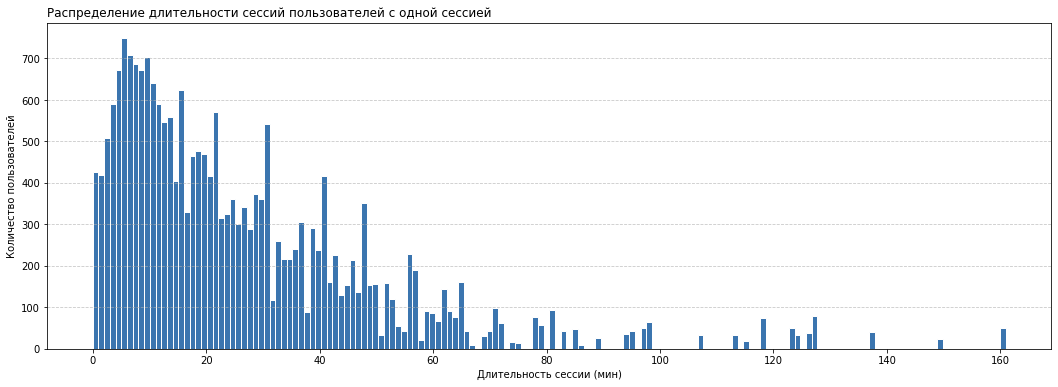

In [148]:
# 1. Фильтрация пользователей с одной сессией
one_session_users = df[df['sessions_count'] == 1]

# 2. Построение гистограммы по session_duration
plt.figure(figsize=(18, 6))
plt.hist(one_session_users['session_duration'].dropna(), bins=160, color='#3b75af', edgecolor='white')
plt.title('Распределение длительности сессий пользователей с одной сессией', loc='left')
plt.xlabel('Длительность сессии (мин)')
plt.ylabel('Количество пользователей')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [149]:
# 1. Фильтрация пользователей с одной сессией и session_duration < 1 мин
short_sessions = one_session_users[one_session_users['session_duration'] < 1]

# 2. Подсчёт уникальных пользователей
unique_users = short_sessions['user_id'].nunique()

print(f"Количество пользователей с одной сессией и session_duration < 1 мин: {unique_users}")

Количество пользователей с одной сессией и session_duration < 1 мин: 158


**Вывод**
- Из пользователей с одной сессией, 158 человек (3.68%) завершили сессию менее чем за 1 минуту. Это небольшая доля, которая может указывать на технические или UX проблемы или низкую вовлечённость для части пользователей. Но больших проблем нет, иначе доля была бы выше.

##### Подсчитать среднее время сессии для каждого пользователя.

In [150]:
user_avg_session = (
    session_times
    .groupby('user_id')['session_duration']
    .mean()
    .reset_index(name='avg_session_duration')
)

user_avg_session.head()


,user_id,avg_session_duration
0,0001b1d5-b74a-4cbf-aeb0-7df5947bf349,11.502325
1,00157779-810c-4498-9e05-a1e9e3cedf93,32.706133
2,00463033-5717-4bf1-91b4-09183923b9df,24.707917
3,004690c3-5a84-4bb7-a8af-e0c8f8fca64e,18.456553
4,00551e79-152e-4441-9cf7-565d7eb04090,3.109250


In [151]:
# Посмотрим описательную статистику
user_avg_session['avg_session_duration'].describe().to_frame()

,avg_session_duration
count,4293.000000
mean,14.258788
std,15.726131
min,0.000000
25%,3.978383
50%,9.376122
75%,19.155100
max,161.014867


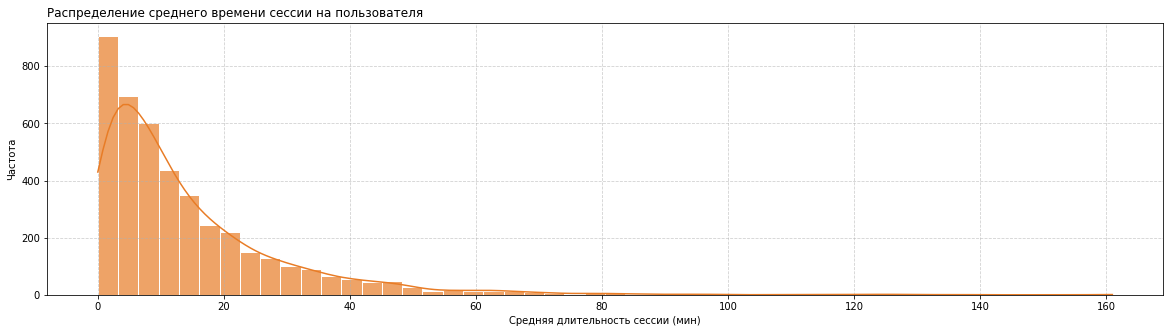

In [152]:
# Изучим распределение среднего времени сессии по пользователям

plt.figure(figsize=(20, 5))
sns.histplot(user_avg_session['avg_session_duration'], bins=50, kde=True,
             color="#E87C26", alpha=0.7, edgecolor='white')
plt.title('Распределение среднего времени сессии на пользователя', loc='left')
plt.xlabel('Средняя длительность сессии (мин)')
plt.ylabel('Частота')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [153]:
# Пользователи со средней сессией равной 0
zero_session_users = user_avg_session[user_avg_session['avg_session_duration'] == 0]
print(
    f'Пользователей со средней сессией равной 0: '
    f'{zero_session_users.shape[0]}'
)


# Пользователи со средней сессией менее 1 минуты
short_session_users = user_avg_session[user_avg_session['avg_session_duration'] < 1]
print(
    f'Пользователей со средней сессией менее 1 минуты: '
    f'{short_session_users.shape[0]}'
)

# Пользователи с длинными сессиями (дольше 95% перцентиля)
long_threshold = user_avg_session['avg_session_duration'].quantile(0.95)
long_session_users = user_avg_session[user_avg_session['avg_session_duration'] > long_threshold]
print(
    f'Пользователей со средней сессией дольше {long_threshold:.2f} минут: '
    f'{long_session_users.shape[0]}'
)


Пользователей со средней сессией равной 0: 83
Пользователей со средней сессией менее 1 минуты: 360
Пользователей со средней сессией дольше 44.02 минут: 215


**Вывод:**  

- **Общее количество пользователей**: 4293. Среднее время сессии на пользователя: **14.26 минут**. Медиана: **9.38 минут**. 75% пользователей имеют среднюю сессию **менее 19.16 минут**. Максимальная средняя сессия: **161 минут**. Стандартное отклонение: **15.73 минут** — значительный разброс, что указывает на наличие пользователей с аномально длинными сессиями.  


- **Присутствует группа пользователей с крайне короткими сессиями**. 83 пользователя (около **2%**) имеют среднюю сессию **равную 0** — вероятно, это сбои в логах или мгновенный выход из приложения. 360 пользователей (около **8%**) имеют среднее время сессии **менее 1 минуты** — это может указывать на низкую вовлечённость или тестовые аккаунты.  


- **Длинные сессии (выше 95-го перцентиля)**: 215 пользователей (около **5%**) имеют среднее время сессии **дольше 44.02 минут**. Эти пользователи могут представлять выбросы или интенсивное использование приложения.

In [154]:
# Считаем количество событий для сессий с нулевой длительностью
event_distribution = df[df['session_duration'] == 0]['event_name'].value_counts()

event_distribution.to_frame()


,event_name
tips_show,892
photos_show,513
search,377
show_contacts,124
map,98
advert_open,45
favorites_add,30
tips_click,10


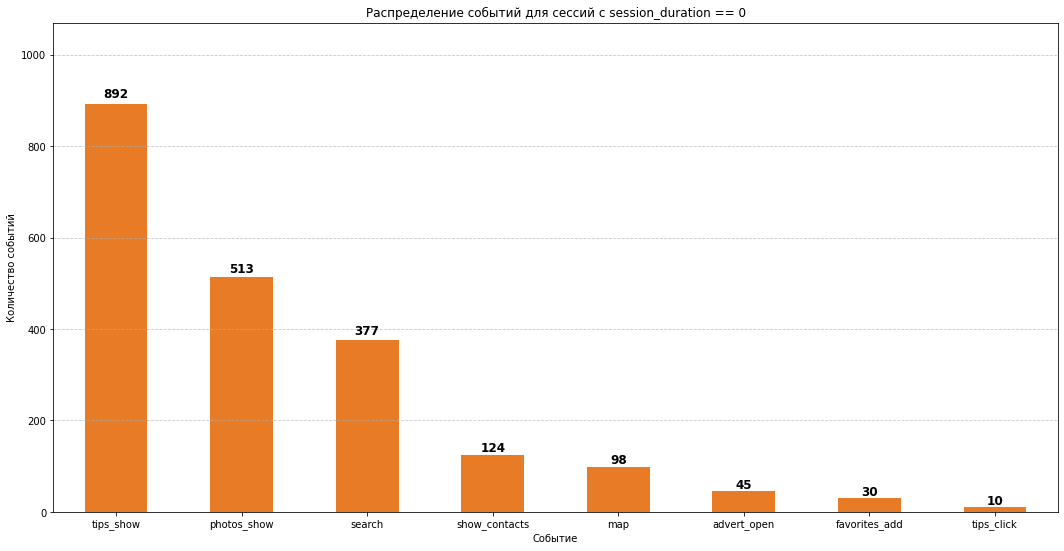

In [155]:
plt.figure(figsize=(18, 9))
ax = event_distribution.plot(kind='bar', color='#E87C26')  # Устанавливаем цвет столбцов
plt.title('Распределение событий для сессий с session_duration == 0')
plt.xlabel('Событие')
plt.ylabel('Количество событий')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Автоматический подбор отступа для текста
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2,
            i.get_height() + i.get_height() * 0.01,  
            str(int(i.get_height())),
            ha='center', va='bottom',
            fontsize=12, color='black', weight='bold')

# Ограничиваем верхнюю границу по оси Y для аккуратности
plt.ylim(0, event_distribution.max() * 1.2)

plt.show()


**Вывод:**

Наиболее часто встречается событие tips_show (892), скорее всего это первое событие при входе в приложение (в начале пользовательского пути). Это позволяет предположить, что это не программный сбой, а поведение пользователей, которые быстро открыли и закрыли приложение. В целом нулевые сессии с событиями типа  photos_show, search, show_contacts, maps и остальные похожи на то, что ранее пользователь остановился на каком-то этапе поиска товара, и в какой-то момент открыл и быстро закрыл приложение (возможно случайно). 


#### Частота действий:
- Рассчитать, сколько действий в среднем совершает пользователь.
- Построить распределение по количеству действий.

- Рассчитать количество событий (по дням, по дням недели).
- Визуализация количества событий (по дням, по дням недели).

##### Распределение количества событий

In [156]:
# Считаем количество событий для каждого пользователя
events_per_user = df.groupby('user_id').size()

# Сколько людей совершили ровно одно действие
users_with_one_event = events_per_user[events_per_user == 1].shape[0]
print("Пользователей, совершивших только 1 действие:", users_with_one_event)

Пользователей, совершивших только 1 действие: 65


Посмотрим ещё распределение событий для пользователей с одной сессией и нулевой продолжительностью

In [157]:
# Фильтрация пользователей с одной сессией и session_duration == 0:
one_session_zero_duration = df[
    (df['sessions_count'] == 1) & (df['session_duration'] == 0)
]

# Подсчёт количества событий:
event_distribution = one_session_zero_duration['event_name'].value_counts()
event_distribution.to_frame()

,event_name
tips_show,30
map,16
search,8
show_contacts,6
photos_show,4
advert_open,1


В половине случаев событие - tips_show (скорее всего первое событие при входе в приложение). Остальные могли прийти по ссылке откуда-то, но быстро закрыть приложение.
Таких событий совсем немного, это скорее нормальная ситуация.

In [158]:
# Посмотреть описательные статистики
events_per_user.describe()

count    4293.000000
mean       17.272304
std        29.089254
min         1.000000
25%         5.000000
50%         9.000000
75%        17.000000
max       477.000000
dtype: float64

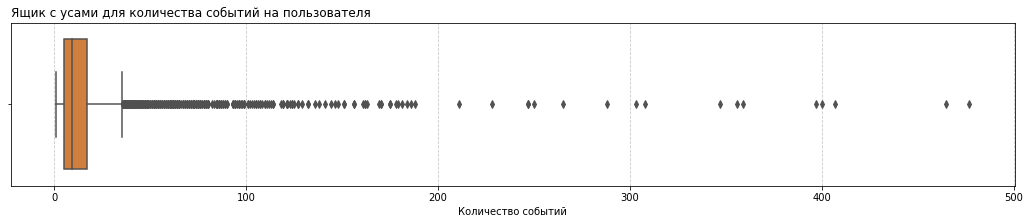

In [159]:
# Строим boxplot
plt.figure(figsize=(18, 3))
sns.boxplot(x=events_per_user, color='#E87C26')
plt.title('Ящик с усами для количества событий на пользователя', loc='left')
plt.xlabel('Количество событий')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

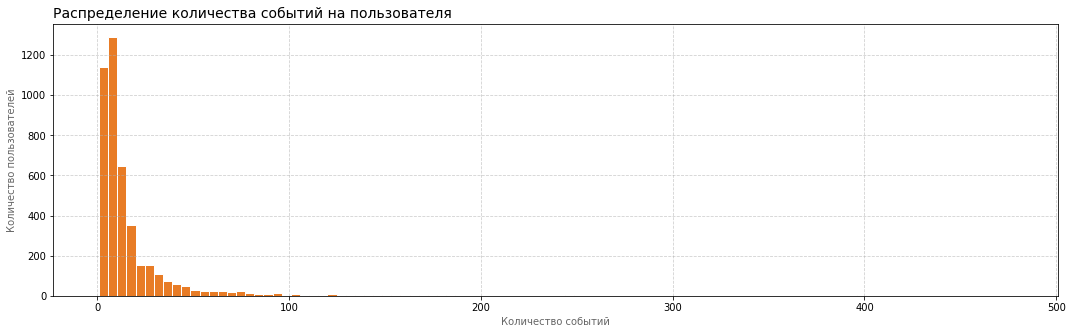

In [160]:
# Строим гистограмму
plt.figure(figsize=(18, 5))
plt.hist(events_per_user, bins=100, color="#E87C26", edgecolor='white')
plt.title('Распределение количества событий на пользователя', fontsize=14, loc='Left')
plt.xlabel('Количество событий', alpha=0.6)
plt.ylabel('Количество пользователей', alpha=0.6)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

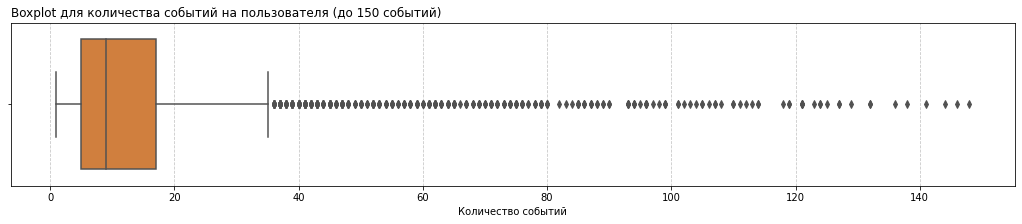

In [161]:
# Ограничиваем количество событий на пользователя цифрой 150
events_per_user_limited = events_per_user[events_per_user <= 150]

# Строим boxplot
plt.figure(figsize=(18, 3))
sns.boxplot(x=events_per_user_limited, color='#E87C26')
plt.title('Boxplot для количества событий на пользователя (до 150 событий)', loc='left')
plt.xlabel('Количество событий')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

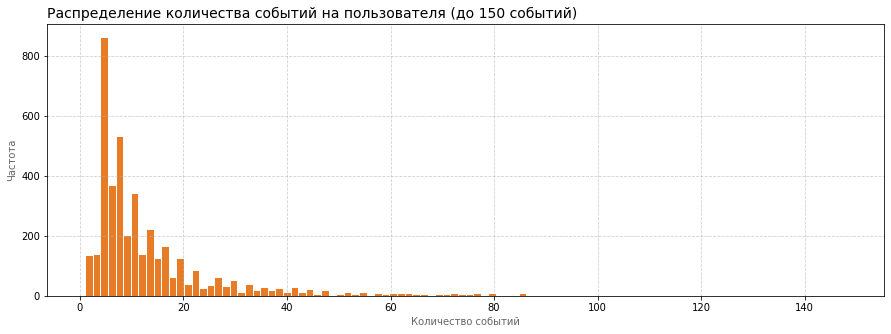

In [162]:
# Строим гистограмму
plt.figure(figsize=(15, 5))
plt.hist(events_per_user_limited, bins=100, color="#E87C26", edgecolor='white')
plt.title('Распределение количества событий на пользователя (до 150 событий)', 
          fontsize=14, loc='Left')
plt.xlabel('Количество событий', alpha=0.6)
plt.ylabel('Частота', alpha=0.6)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

**Вывод:**
- Всего в выборке **4293** пользователя. **65** человек (около 1,5%) совершили ровно одно действие. Медиана равна **9**, а среднее около **17** — это говорит о смещении распределения вправо из-за «длинного хвоста». 25% пользователей имеют **5** и менее событий, 75% — **17** и менее. Большинство укладывается в диапазон **5–17**. Максимальное значение равно **477** событий: единичные «суперактивные» пользователи формируют выбросы и сильно повышают среднее.


- Большинство пользователей совершают менее **20 событий**, с пиком частоты около **5 событий**. Число пользователей, совершающих **от 20 до 50 событий**, значительно уменьшается, и после **50 событий** активность становится крайне редкой. Это распределение подтверждает, что основная часть пользователей взаимодействует с приложением минимально.

##### Рассчет количества событий по дням

In [163]:
# Добавляем колонку с датой
df['event_date'] = df['event_time'].dt.date

# Считаем количество событий по дням
events_by_day = df.groupby('event_date').size().reset_index(name='event_count')

# Результат
events_by_day

,event_date,event_count
0,2019-10-07,2544
1,2019-10-08,2496
2,2019-10-09,2026
3,2019-10-10,2242
4,2019-10-11,2030
5,2019-10-12,1840
6,2019-10-13,2632
7,2019-10-14,3032
8,2019-10-15,2722
9,2019-10-16,2728


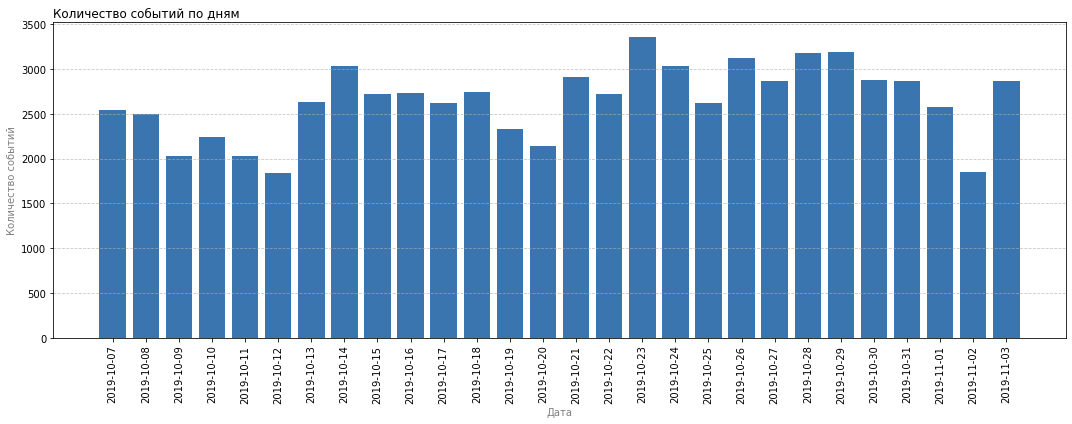

In [164]:
plt.figure(figsize=(15, 6))
plt.bar(events_by_day['event_date'], events_by_day['event_count'], color='#3b75af')

plt.title('Количество событий по дням', loc='left')
plt.xlabel('Дата', alpha=0.5)
plt.ylabel('Количество событий', alpha=0.5)

# Настройка меток оси X
plt.xticks(events_by_day['event_date'], 
           events_by_day['event_date'], 
           rotation=90)  # Указываем каждую дату как метку

plt.grid(axis='y', linestyle='--', alpha=0.7)  # Горизонтальная сетка
plt.tight_layout()  # Уменьшаем отступы для лучшего отображения
plt.show()


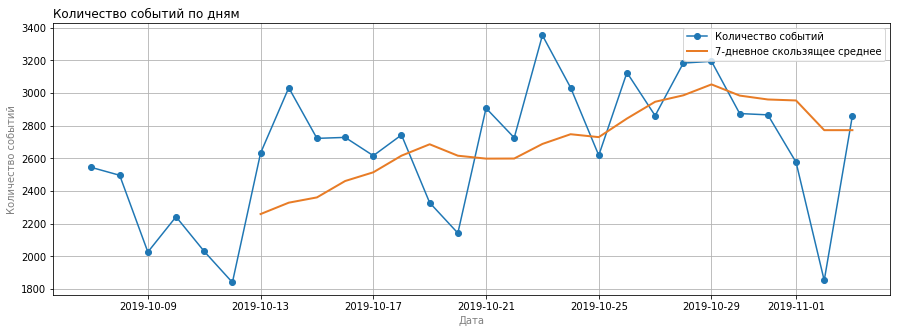

In [165]:
plt.figure(figsize=(15, 5))
plt.plot(events_by_day['event_date'], events_by_day['event_count'], marker='o', label='Количество событий')

# Добавляем скользящее среднее (7 дней)
rolling_avg = events_by_day['event_count'].rolling(window=7).mean()
plt.plot(events_by_day['event_date'], rolling_avg, color='#E87C26', linewidth=2, label='7-дневное скользящее среднее')

plt.title('Количество событий по дням', loc='left')
plt.xlabel('Дата', alpha=0.5)
plt.ylabel('Количество событий', alpha=0.5)
plt.grid()
plt.legend()  # Добавляем легенду
plt.show()


**Вывод:**
- Активность пользователей приложения колеблется, с пиками 23 октября (3353 события) и 28-29 октября (3183-3194 события). Минимальная активность наблюдается 2 ноября (1852 события). 


- Активность в большинстве дней держится на уровне 2500–3000 событий.


- В конце октября активность стабильно высокая, выше, чем в начале периода.

##### Рассчет количества событий по дням недели

In [166]:
# Добавляем колонку с днем недели
df['day_of_week'] = df['event_time'].dt.day_name()

# Считаем количество событий по дням недели
events_by_weekday = df.groupby('day_of_week').size().reset_index(name='event_count')

# Упорядочим дни недели
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
events_by_weekday['day_of_week'] = pd.Categorical(events_by_weekday['day_of_week'], categories=days_order, ordered=True)
events_by_weekday = events_by_weekday.sort_values('day_of_week')

# Результат
events_by_weekday

,day_of_week,event_count
1,Monday,11666
5,Tuesday,11138
6,Wednesday,10981
4,Thursday,10757
0,Friday,9967
2,Saturday,9145
3,Sunday,10496


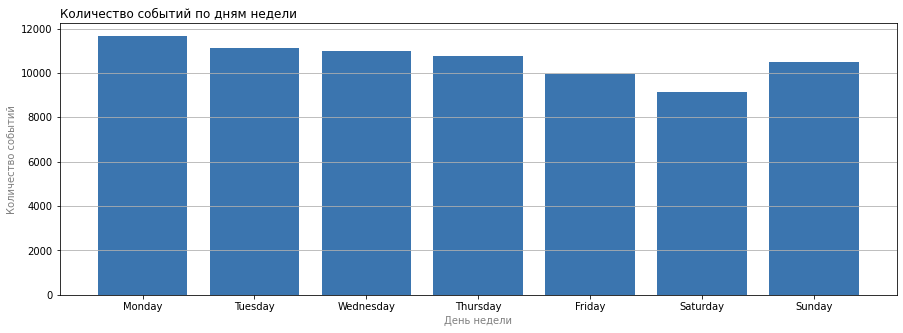

In [167]:
plt.figure(figsize=(15, 5))
plt.bar(events_by_weekday['day_of_week'], events_by_weekday['event_count'], color='#3b75af')
plt.title('Количество событий по дням недели', loc='left')
plt.xlabel('День недели', alpha=0.5)
plt.ylabel('Количество событий', alpha=0.5)
plt.grid(axis='y')
plt.show()

**Вывод:**
- Активность выше в начале недели и снижается к выходным. Наибольшее количество событий в приложении происходит в понедельник (**11666** событий), после чего активность постепенно снижается к пятнице (**9967** событий) и субботе (**9145** событий). Воскресенье показывает умеренный рост активности (**10496** событий). 

#### Конверсия в целевое действие:
- Рассчитать процент пользователей, которые совершили действие contacts_show.

In [168]:
# Определяем общее количество уникальных пользователей
total_users = df['user_id'].nunique()

# Определяем пользователей, совершивших целевое действие
target_users = df[df['event_name'] == 'show_contacts']['user_id'].nunique()

#Рассчитываем конверсию
conversion_rate = (target_users / total_users) * 100
print(f'Конверсия в show_contacts: {conversion_rate:.2f}%')

Конверсия в show_contacts: 22.85%


##### По событиям

In [169]:
# Зададим функцию для рассчета конверсии по событиям (кто совершает это событие и не совершает)
def calculate_conversion(df, action_event, target_event='show_contacts'):
    # Пользователи, совершившие action_event
    action_users = df[df['event_name'] == action_event]['user_id'].unique()
    
    # Пользователи, совершившие target_event
    target_users = df[df['event_name'] == target_event]['user_id'].unique()
    
    # Конверсия среди тех, кто делал action_event
    conversion_with_action = len(set(action_users) & set(target_users)) / len(action_users) * 100
    
    # Пользователи, которые не делали action_event
    all_users = df['user_id'].unique()
    no_action_users = set(all_users) - set(action_users)
    
    # Конверсия среди тех, кто не делал action_event
    conversion_without_action = len(set(no_action_users) & set(target_users)) / len(no_action_users) * 100
    
    print(f'Конверсия с {action_event}: {conversion_with_action:.2f}%')
    print(f'Конверсия без {action_event}: {conversion_without_action:.2f}%')
    return conversion_with_action, conversion_without_action


In [170]:
# Получаем список уникальных событий
unique_events = df['event_name'].unique()

# Применяем функцию к каждому событию
for event in unique_events:
    calculate_conversion(df, event)
    print('-' * 35)  # Разделитель между событиями

Конверсия с tips_show: 18.42%
Конверсия без tips_show: 31.17%
-----------------------------------
Конверсия с map: 19.85%
Конверсия без map: 24.39%
-----------------------------------
Конверсия с search: 22.63%
Конверсия без search: 22.99%
-----------------------------------
Конверсия с photos_show: 30.96%
Конверсия без photos_show: 20.08%
-----------------------------------
Конверсия с favorites_add: 38.75%
Конверсия без favorites_add: 21.44%
-----------------------------------
Конверсия с show_contacts: 100.00%
Конверсия без show_contacts: 0.00%
-----------------------------------
Конверсия с contacts_call: 100.00%
Конверсия без contacts_call: 18.82%
-----------------------------------
Конверсия с advert_open: 18.38%
Конверсия без advert_open: 23.80%
-----------------------------------
Конверсия с tips_click: 31.06%
Конверсия без tips_click: 22.19%
-----------------------------------


Высокая конверсия для `favorites_add`, `photos_show`, `tips_click`

- `favorites_add` — 38.75% среди добавивших в избранное против 21.44% среди тех, кто не использовал эту функцию. Это может указывать на заинтересованность пользователей в объявлениях, которые они сохраняют.


- `photos_show` — 30.96% среди тех, кто просматривал фотографии, против 20.08% среди тех, кто не просматривал. Это подтверждает, что визуальный контент положительно влияет на принятие решения.


- `tips_click` — 31.06% против 22.19%. Пользователи, которые взаимодействуют с рекомендациями, чаще совершают целевые действия.


- `search` — 22.63% против 22.99%. Взаимодействие с поиском практически не влияет на конверсию.


- `map` — 19.85% против 24.39%. Пользователи, открывающие карту, реже совершают `show_contacts`, что может указывать на то, что они ищут альтернативные варианты или находятся на стадии выбора.


- `tips_show` — 18.42% против 31.17%. Пользователи, которые видели рекомендации, но не кликали по ним, показывают более низкую конверсию, что может указывать на недостаточную релевантность рекомендаций. Но тут сложно сделать однозначный вывод, поскольку скорее всего автоматическое событие, которое происходит первым при заходе в приложение и при заходе на карточку товара, а ещё больше половины пользователей отваливаются после первой сессии.


- `advert_open` — 18.38% против 23.80%. Открытие объявления само по себе не сильно влияет на конверсию, что может указывать на недостаточное привлечение через текст объявлений.

#### По числу сессий

In [171]:
# 1. Создаём категориальную колонку для группировки по количеству сессий
df['session_group'] = pd.cut(
    df['sessions_count'], 
    bins=[0, 1, 2, 3, 4, 5, float('inf')],  # Добавляем границы до 7
    labels=['1', '2', '3', '4', '5', '>5']  # Названия категорий
)

# 2. Считаем общее количество пользователей в каждой группе
total_users = df.groupby('session_group')['user_id'].nunique()

# 3. Считаем пользователей с событием show_contacts
show_contacts_users = (
    df[df['event_name'] == 'show_contacts']
    .groupby('session_group')['user_id']
    .nunique()
)

# 4. Расчёт конверсии
conversion_rate = (show_contacts_users / total_users) * 100
conversion_rate = conversion_rate.fillna(0)

# 5. Вывод результата
print(total_users)
conversion_rate

session_group
1     2300
2      878
3      462
4      239
5      109
>5     305
Name: user_id, dtype: int64


session_group
1     14.782609
2     22.209567
3     34.415584
4     30.962343
5     42.201835
>5    54.754098
Name: user_id, dtype: float64

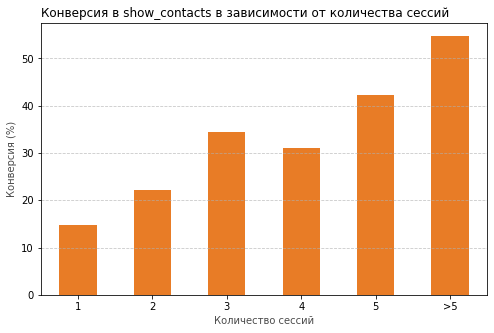

In [172]:
plt.figure(figsize=(8, 5))
conversion_rate.plot(kind='bar', color='#E87C26')
plt.title('Конверсия в show_contacts в зависимости от количества сессий', loc='left')
plt.xlabel('Количество сессий', alpha=0.7)
plt.ylabel('Конверсия (%)', alpha=0.7)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Вывод:**

- Пользователи с 1 сессией имеют конверсию около 14.78%. При 2 сессиях конверсия увеличивается до 22.21%. 3-5 сессий дают стабильно высокий рост конверсии, достигая 42.20% для пользователей с 5 сессиями. Пользователи с более чем 5 сессиями имеют максимальную конверсию — 54.75%.


- Конверсия в show_contacts практически линейно растёт по мере увеличения числа сессий. Это указывает на то, что пользователи с большим количеством сессий имеют более высокий уровень вовлечённости и чаще выполняют целевое действие.

#### По длительности сессий

In [173]:
df['session_duration_group'] = pd.cut(
    df['session_duration'], 
    bins=[-1, 1, 5, 15, 30, 60, float('inf')],  # <1 мин, 1-5 мин, 5-15 мин, 15-30 мин и т.д.
    labels=['<1 min', '1-5 min', '5-15 min', '15-30 min', '30-60 min', '>60 min']
)

# Группировка пользователей по длительности сессий
duration_segment = df.groupby('session_duration_group')['user_id'].nunique().reset_index()
duration_segment.columns = ['session_duration_group', 'user_count']

# Вывод чисел по группам
duration_segment

,session_duration_group,user_count
0,<1 min,1449
1,1-5 min,1392
2,5-15 min,1869
3,15-30 min,1280
4,30-60 min,786
5,>60 min,264


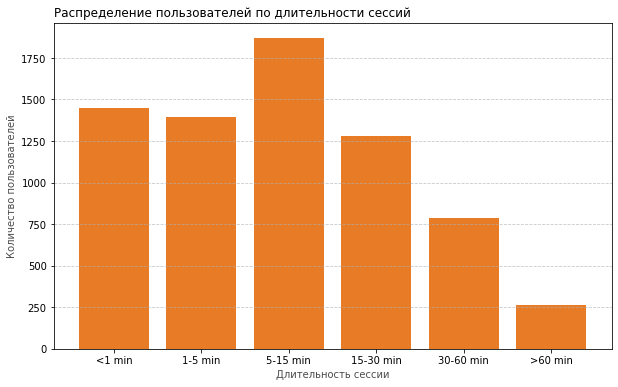

In [174]:
plt.figure(figsize=(10, 6))
plt.bar(duration_segment['session_duration_group'], duration_segment['user_count'], color='#E87C26')
plt.title('Распределение пользователей по длительности сессий', loc='left')
plt.xlabel('Длительность сессии', alpha=0.7)
plt.ylabel('Количество пользователей', alpha=0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [175]:
conversion_by_duration = (
    df[df['event_name'] == 'show_contacts']
    .groupby('session_duration_group')['user_id']
    .nunique()
    / df.groupby('session_duration_group')['user_id'].nunique()
) * 100

conversion_by_duration.to_frame()


,user_id
session_duration_group,
<1 min,15.873016
1-5 min,17.169540
5-15 min,18.031033
15-30 min,20.859375
30-60 min,26.463104
>60 min,35.984848


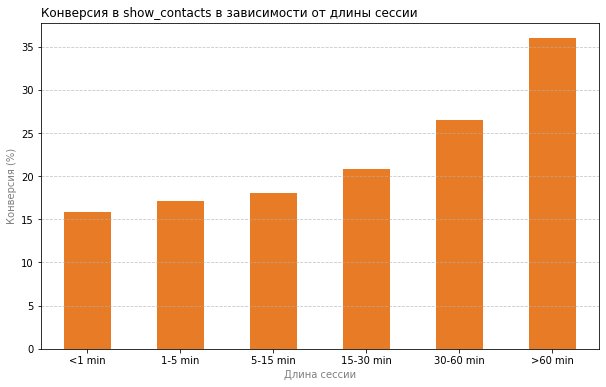

In [176]:
# 8. Визуализация
plt.figure(figsize=(10, 6))
conversion_by_duration.plot(kind='bar', color='#E87C26')
plt.title('Конверсия в show_contacts в зависимости от длины сессии', loc='left')
plt.xlabel('Длина сессии', alpha=0.5)
plt.ylabel('Конверсия (%)', alpha=0.5)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Вывод:**

**Распределение пользователей по длительности сессий:** Больше всего пользователей проводят в приложении от 5 до 15 минут — это самый многочисленный сегмент. Второй по величине сегмент — сессии 1-5 минут. Меньше всего пользователей проводят в приложении более 60 минут — это редкое явление.

**Конверсия в целевое действие (show_contacts):**
Конверсия увеличивается с ростом длительности сессий: <1 мин — 15.87% (самая низкая конверсия). 1-5 мин — 17.17%. 5-15 мин — 18.03%. 30-60 мин — 26.46%. >60 мин — 35.98% (самая высокая конверсия).

**Ключевые выводы:**
Пользователи с длительными сессиями (>30 мин) конвертируются почти в два раза чаще, чем пользователи с сессиями менее 1 минуты.
Самая низкая конверсия наблюдается у пользователей с короткими сессиями (<1 мин), что может указывать на быстрое завершение сеанса, отсутствие интереса или технические проблемы.

**Рекомендации:**
Анализировать пользователей с короткими сессиями и выявить причины быстрой деактивации. Стимулировать пользователей с короткими сессиями к продолжению работы с приложением (например, через персонализированные предложения или уведомления). Фокус на удержание пользователей с сессиями 15+ минут, так как они имеют наиболее высокий потенциал конверсии.


## Сегментация пользователей
### По источнику установки:
Деление на группы по source: yandex, google, other. Это позволит оценить эффективность различных рекламных каналов.

Обоснование:
Источник установки напрямую влияет на поведение пользователя в приложении. Разные рекламные каналы могут привлекать аудиторию с различной степенью вовлечённости. Например:

- Пользователи из `Yandex` могут демонстрировать высокий уровень доверия к сервису, так как это локальная платформа.
- `Google` часто привлекает более широкий круг пользователей, но конверсия может быть ниже из-за высокого трафика.
- Прочие источники (`other`) могут включать органический трафик или рекламные кампании в соцсетях, что тоже влияет на поведение.

То есть это позволит выявить, какой канал приносит наиболее заинтересованных пользователей и поможем сэкономить на неэффективных рекламных кампаниях. Если окажется, что пользователи из опрделенного источника чаще совершают целевые действия, то заказчику имеет смысл усилить рекламную активность в этой сети.

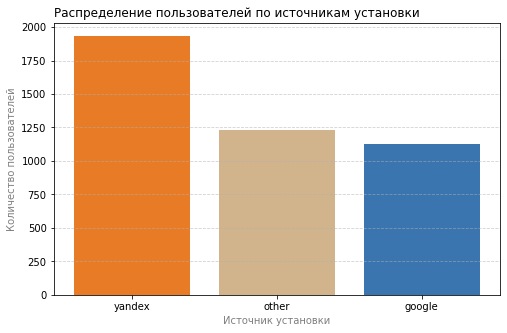

In [177]:
# Группировка пользователей по источнику установки
source_segment = df.groupby('source')['user_id'].nunique().reset_index()
source_segment.columns = ['source', 'user_count']

# Сортировка по убыванию
source_segment = source_segment.sort_values(by='user_count', ascending=False)

# Визуализация распределения пользователей по источникам
plt.figure(figsize=(8, 5))
plt.bar(source_segment['source'], source_segment['user_count'], color=['#E87C26', '#D2B48C', '#3b75af'])
plt.title('Распределение пользователей по источникам установки', loc='left')
plt.xlabel('Источник установки', alpha=0.5)
plt.ylabel('Количество пользователей', alpha=0.5)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()


Больше всего пользователей приходят из канала `yandex`

Ответим на вопрос:  пользователи какой группы часто делают целевое событие (конверсия в целевое действие)?

In [178]:
# Считаем конверсию в show_contacts для каждого источника
conversion_by_source = (
    df[df['event_name'] == 'show_contacts']
    .groupby('source')['user_id']
    .nunique()
    / df.groupby('source')['user_id'].nunique()
) * 100

conversion_by_source.to_frame()


,user_id
source,
google,24.357839
other,18.536585
yandex,24.715615


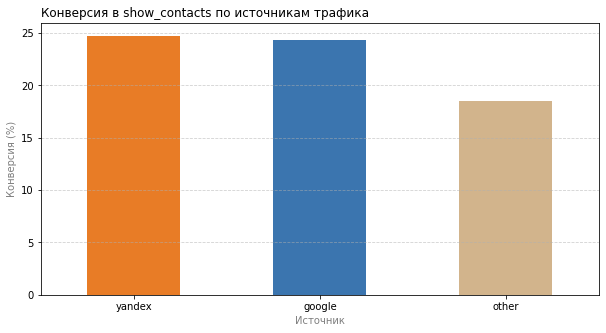

In [179]:
# Визуализация конверсии по каналам
conversion_by_source.sort_values(ascending=False).plot(kind='bar', figsize=(10, 5), color=['#E87C26', '#3b75af', '#D2B48C'])
plt.title('Конверсия в show_contacts по источникам трафика', loc='left')
plt.ylabel('Конверсия (%)', alpha=0.5)
plt.xlabel('Источник', alpha=0.5)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.show()

**Вывод**

- **Распределение пользователей:** Больше всего пользователей пришли из Яндекса (yandex) — около 1800 человек. На втором месте — пользователи из категории other (примерно 1250). Меньше всего пользователей установили приложение через Google (около 1100).


- **Конверсия в целевое действие (show_contacts)**. Яндекс показывает наивысшую конверсию — 24.72%. Google немного уступает — 24.36%. Пользователи из категории other демонстрируют самую низкую конверсию — 18.54%.


Следующая задача: определить, пользователи какой группы склонны часто возвращаться в мобильное приложение (retention rate)?

In [180]:
# Создаем пустой словарь для хранения результатов по каждому источнику
retention_by_source = {}

# Рассчитываем retention rate для каждого источника
for source in df['source'].unique():
    filtered_df = df[df['source'] == source].copy()  # создаем копию DataFrame
    retention_by_source[source] = calculate_retention(filtered_df)

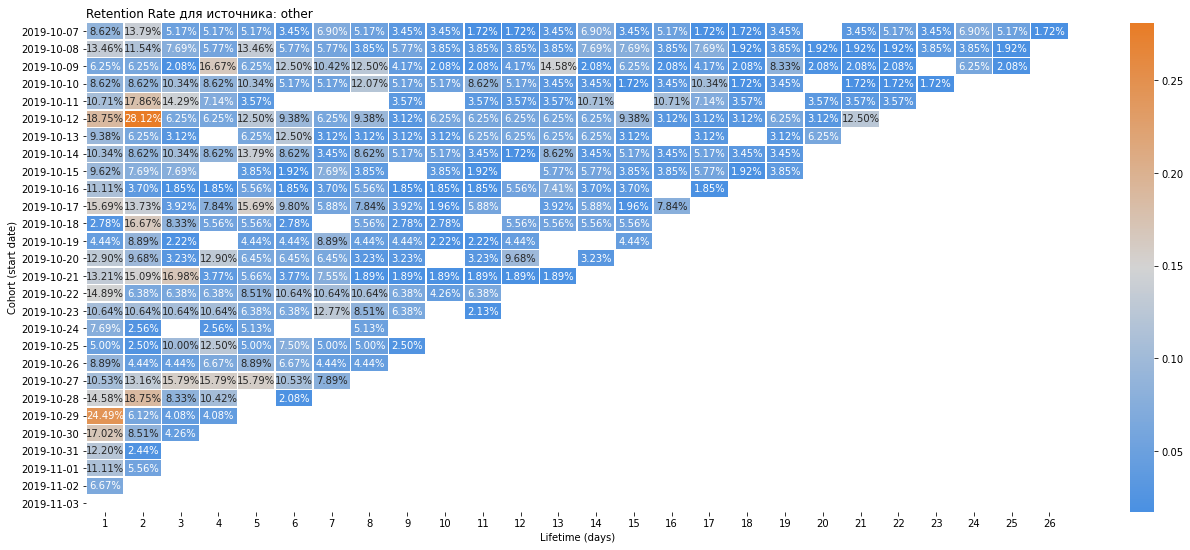

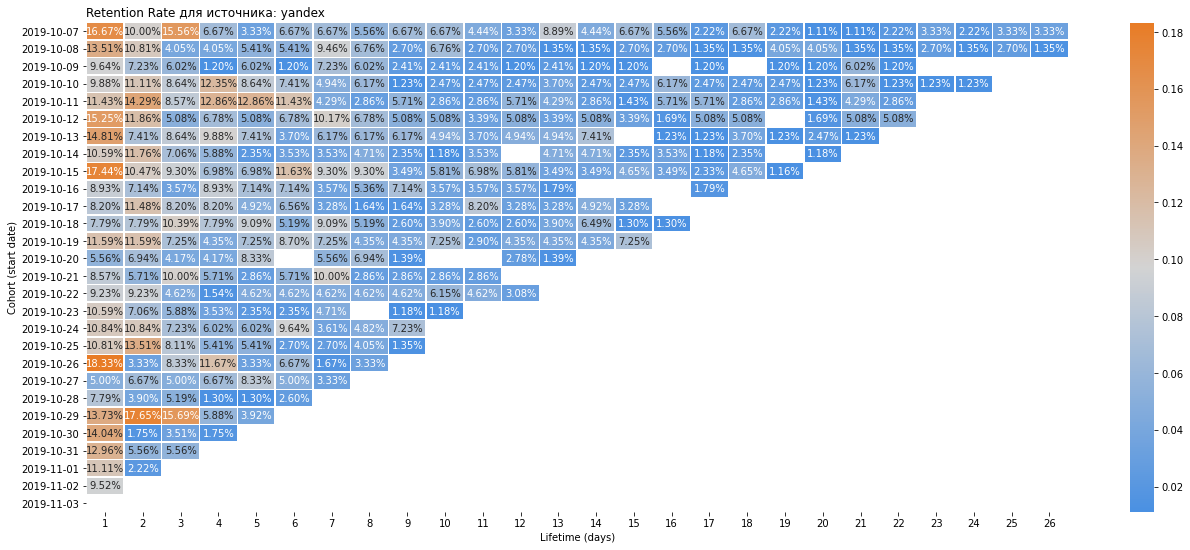

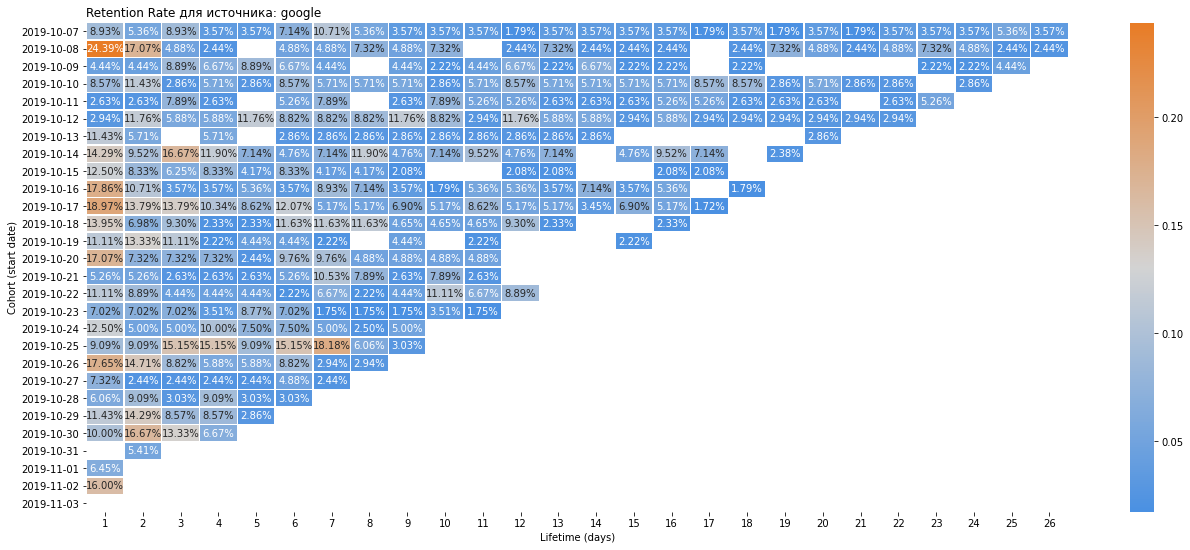

In [181]:
# Визуализируем retention rate для каждой группы источников
for source, retention in retention_by_source.items():
    plot_retention_heatmap(retention, title=f'Retention Rate для источника: {source}')


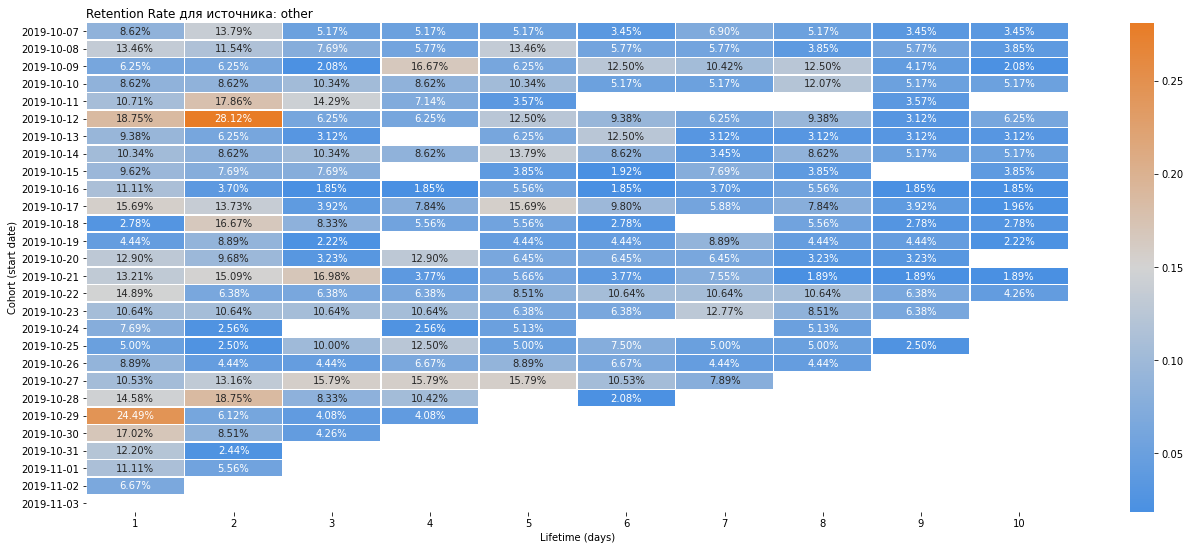

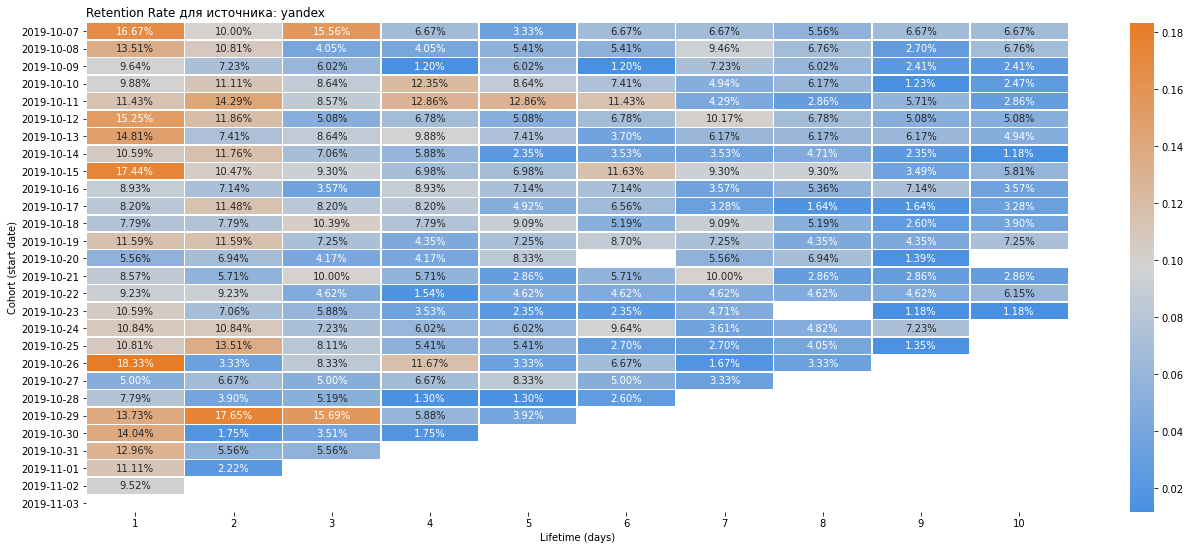

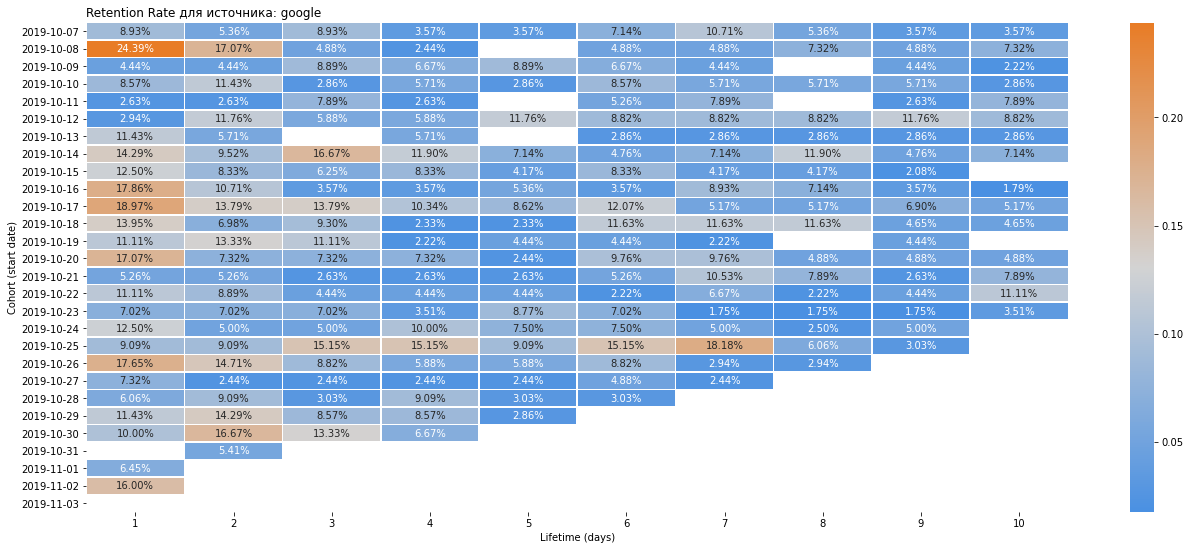

In [182]:
# Посмотрим с горизонтом анализа в 10 дней
for source, retention in retention_by_source.items():
    plot_retention_heatmap(
        retention,
        title=f'Retention Rate для источника: {source}',
        horizon_days=10  # добавляем горизонт анализа
    )

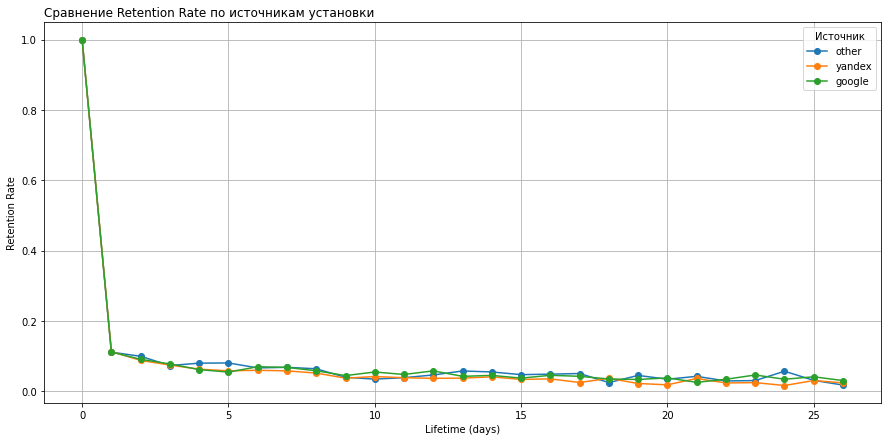

In [183]:
plt.figure(figsize=(15, 7))

for source, retention in retention_by_source.items():
    plt.plot(
        retention.columns,
        retention.mean(),  # средний retention по когортам
        marker='o',
        label=f'{source}'
    )

plt.title('Сравнение Retention Rate по источникам установки', loc='left')
plt.xlabel('Lifetime (days)')
plt.ylabel('Retention Rate')
plt.legend(title='Источник')
plt.grid(True)
plt.show()


**Вывод:**

- Проблема низкого удержания после первого дня примерно одинакова для всех источников, то есть главная проблема скорее в первой сессии пользователя (возможно, непонятный интерфейс).


- Yandex и Google демонстрируют схожую кривую удержания, схожие высокие показатели удержания по сравнению с источником "other".
Yandex показывает более высокое удержание на 2ой день.


- Yandex - самый эффективный канал - привлекает больше всего пользователей, самое высокое удержание на проблемный второй день, самая высокая конверсия.


- Источник "other" демонстрирует самое низкое удержание, что может говорить о менее целевой аудитории или слабом качестве привлеченных пользователей.

### По поведению:
Сегментировать пользователей на основе их активности:
Активные — пользователи с большим числом сессий и длительным временем в приложении.
Среднеактивные — пользователи с 2-5 сессиями.
Неактивные (отток) — пользователи с 1 сессией или короткими сессиями (менее 1 минуты).


Кластер 1 — пользователи с одной сессией и минимальной вовлечённостью.
Кластер 2 — пользователи с несколькими сессиями и умеренной активностью.
Кластер 3 — активные пользователи с высокой длительностью сессий.
Кластер 4 — «суперактивные» пользователи с максимальным числом сессий и вовлечённостью.

## Проверка Гипотез

###  Первая гипотеза:
Некоторые пользователи установили приложение по ссылке из yandex, другие — из google . Проверка гипотезы: две эти группы
демонстрируют разную конверсию в просмотры контактов.

**Нулевая гипотеза (H₀):** Нет разницы в конверсии в просмотры контактов между пользователями из yandex и google.

**Альтернативная гипотеза (H₁):** Конверсия в просмотры контактов различается между этими группами.

Провести статистический Z-тест для пропорций (позволяет сравнить доли успехов (конверсии) в двух независимых группах)



In [184]:
# 1. Подсчёт количества пользователей из yandex и google
yandex_users = df[df['source'] == 'yandex']['user_id'].nunique()
google_users = df[df['source'] == 'google']['user_id'].nunique()

# 2. Подсчёт пользователей, совершивших show_contacts (конверсии)
yandex_converted = df[(df['source'] == 'yandex') & (df['event_name'] == 'show_contacts')]['user_id'].nunique()
google_converted = df[(df['source'] == 'google') & (df['event_name'] == 'show_contacts')]['user_id'].nunique()

# 3. Пропорции конверсии
yandex_conversion = yandex_converted / yandex_users
google_conversion = google_converted / google_users

# 4. Подготовка данных для Z-теста
counts = np.array([yandex_converted, google_converted])  # Количество успехов
nobs = np.array([yandex_users, google_users])  # Общее количество наблюдений

# 5. Выполнение Z-теста
z_stat, p_value = proportions_ztest(counts, nobs)

# 6. Вывод результатов
print(f'Конверсия из Yandex: {yandex_conversion:.2%}')
print(f'Конверсия из Google: {google_conversion:.2%}')
print(f'p-value: {p_value:.4f}')

# 7. Интерпретация
alpha = 0.05
if p_value < alpha:
    print("Отклоняем нулевую гипотезу. Конверсии различаются.")
else:
    print("Не удалось отклонить нулевую гипотезу. Конверсии не различаются.")

Конверсия из Yandex: 24.72%
Конверсия из Google: 24.36%
p-value: 0.8244
Не удалось отклонить нулевую гипотезу. Конверсии не различаются.


###  Собственная гипотеза:
Пользователи, которые кликают по рекомендованным объявлениям (tips_click), имеют выше конверсию в просмотр контактов (contacts_show / show_contacts) по сравнению с пользователями, которые не кликают по рекомендациям.

**Нулевая гипотеза (H₀):**
Конверсия в просмотр контактов у пользователей, кликающих по рекомендациям, не отличается от конверсии у пользователей, которые не кликают.

**Альтернативная гипотеза (H₁):**
Конверсия в просмотр контактов выше у пользователей, которые кликают по рекомендованным объявлениям.

Также применим Z-тест.

In [185]:
# Подсчёт пользователей, которые кликнули по tips_click
tips_click_users = df[df['event_name'] == 'tips_click']['user_id'].unique()

# 1. Группа пользователей с tips_click
tips_click_group = df[df['user_id'].isin(tips_click_users)]

# 2. Группа пользователей без tips_click
no_tips_click_group = df[~df['user_id'].isin(tips_click_users)]

# 3. Количество пользователей в каждой группе
n_tips_click = tips_click_group['user_id'].nunique()
n_no_tips_click = no_tips_click_group['user_id'].nunique()

# 4. Количество конверсий (show_contacts) в каждой группе
converted_tips_click = tips_click_group[tips_click_group['event_name'] == 'show_contacts']['user_id'].nunique()
converted_no_tips_click = no_tips_click_group[no_tips_click_group['event_name'] == 'show_contacts']['user_id'].nunique()

# 5. Пропорции конверсии
tips_click_conversion = converted_tips_click / n_tips_click
no_tips_click_conversion = converted_no_tips_click / n_no_tips_click

In [186]:
counts = np.array([converted_tips_click, converted_no_tips_click])  # Количество успехов (конверсий)
nobs = np.array([n_tips_click, n_no_tips_click])  # Количество наблюдений

z_stat, p_value = proportions_ztest(counts, nobs, alternative='larger')  # Проверяем, что конверсия tips_click > no_tips_click

# 7. Вывод результатов
print(f'Конверсия пользователей с tips_click: {tips_click_conversion:.2%}')
print(f'Конверсия пользователей без tips_click: {no_tips_click_conversion:.2%}')
print(f'p-value: {p_value:.4f}')

alpha = 0.05

if p_value < alpha:
    print("Отклоняем нулевую гипотезу. Конверсия выше у пользователей с tips_click.")
else:
    print("Не удалось отклонить нулевую гипотезу. Разница в конверсии незначима.")

Конверсия пользователей с tips_click: 31.06%
Конверсия пользователей без tips_click: 22.19%
p-value: 0.0001
Отклоняем нулевую гипотезу. Конверсия выше у пользователей с tips_click.


## Выводы

### Предобработка данных

Данные были предоставлены в виде 2х датафреймов. Они были объединены в один.
Столбцы приведены к snake_case, типы данных — в datetime и object.
Пропуски и явные дубликаты отсутствуют.
Удалено 94 неявных дубликата, размер датасета уменьшился до 74 150 строк.
Объединены дублирующиеся события: show_contacts и search.
Логи разделены на сессии по 30 минут.

### Исследовательский анализ данных

#### Общие характеристики

- Основное событие — `tips_show` с наибольшим количеством действий (40 052), следом идут `photos_show` (9 997) и `search` (6 783). Самые редкие события — `tips_click` (813) и `contacts_call` (541).


- Наибольшее число пользователей наблюдается для события `tips_show` — 2801. Далее идут `search` (1666), `map` (1456), `photos_show` (1095) и `show_contacts` (981). События с наименьшим числом пользователей: `advert_open` (751), `favorites_add` (351), `tips_click` (322) и `contacts_call` (213).


- Данные охватывают период с 7 октября 2019 года до 3 ноября 2019 года. 


- Активность пользователей варьируется, с пиками около 1000 логов в день. В середине и конце периода наблюдаются относительно более высокие значения. Наибольшая активность пользователей наблюдается с 12:00 до 21:00, достигая пика около 15:00. Есть также просадка между 16 и 19 часами. Минимум активности приходится на ночное время (с 2:00 до 6:00).


- Больше всего пользователей приходят из канала `yandex`

#### **Анализ метрик (итог):**  

##### **Retention rate:**  
  - На 2-й день возвращаются **12–16%** пользователей, к 5-му дню показатель падает до **5–8%**.  
  
  
  - Удержание стабилизируется на уровне **2–4%** через 7–8 дней. 
  
  
  - Встречаются аномалии с ростом удержания на более поздних этапах (например, 8.6% на 7-й день).  



##### **Время в приложении:**  
  - **53% пользователей** совершают только одну сессию. **158 пользователей (3.68%)** с одной сессией завершили её за менее 1 минуты. Это небольшая доля, которая может указывать на технические или UX проблемы или низкую вовлечённость для части пользователей. Но больших проблем нет. 
  
  
  - **Средняя длительность сессии:** 12.88 минут (медиана — 5.59 минут).  
  
  
  - **2089 сессий (20%)** с нулевой длительностью. Они были проверены: судя по распределению событий можно предположить, что это не программный сбой, а поведение пользователей, которые быстро открыли и закрыли приложение. **3072 сессии (30%)** короче 1 минуты. **519 сессий (5%)** длиннее **48.52 минут** — возможные выбросы.  


- Средняя сессия на пользователя — **14.26 минут**, медиана — **9.38 минут**. **83 пользователя (2%)** имеют сессию **равную 0**, **360 пользователей (8%)** — **менее 1 минуты**. **215 пользователей (5%)** проводят в приложении более **44 минут**.  


##### Частота действий
  - 25% пользователей совершают **5 и менее событий**, 75% — **17 и менее**.  
  
  - Максимальное количество событий на пользователя — **477**.  
  
  - **65 пользователей (1.5%)** совершают только одно действие.  


##### Активность во времени
  - Пики активности — 23 октября (3353 события) и 28-29 октября (**3183-3194 события**).  
  
  - Максимальная активность — в понедельник (**11 666 событий**), минимальная — в субботу (**9145 событий**).  
  
  - Воскресенье показывает рост активности до **10 496 событий**.  


##### Конверсия

Конверсия в целевое действие (просмотр контактов): **22.85%**.

- **По числу сессий** - Конверсия в show_contacts практически линейно растёт по мере увеличения числа сессий.  Пользователи с 1 сессией имеют конверсию около 14.78%. При 2 сессиях - до 22.21%. Пользователи с более чем 5 сессиями имеют максимальную конверсию — 54.75%.


- **По длительности сессий** Больше всего пользователей проводят в приложении от 5 до 15 минут . Второй по величине сегмент — сессии 1-5 минут. Меньше всего пользователей проводят в приложении более 60 минут — это редкое явление. Конверсия увеличивается с ростом длительности сессий: <1 мин — 15.87% (самая низкая конверсия). 1-5 мин — 17.17%. 5-15 мин — 18.03%. 30-60 мин — 26.46%. >60 мин — 35.98% (самая высокая конверсия).


- **По событиям** Высокая конверсия для событий:


- `favorites_add` — 38.75% среди добавивших в избранное против 21.44% среди тех, кто не использовал эту функцию.


- `photos_show` — 30.96% среди тех, кто просматривал фотографии, против 20.08% среди тех, кто не просматривал.


- `tips_click` — 31.06% против 22.19%. Пользователи, которые взаимодействуют с рекомендациями, чаще совершают целевое действие.



### Сегментация

Была проведена сегментация пользователей по источнику установки (yandex, google, other).

Ответы на вопросы заказчика: 

**Пользователи какой группы часто делают целевое событие (конверсия в целевое действие)?**

- Яндекс показывает наивысшую конверсию — 24.72%. Google немного уступает — 24.36%. Пользователи из категории other демонстрируют самую низкую конверсию — 18.54%.


**Пользователи какой группы склонны часто возвращаться в мобильное приложение (retention rate)?**

- Проблема низкого удержания после первого дня примерно одинакова для всех источников, то есть главная проблема скорее в первой сессии пользователя (возможно, непонятный интерфейс).


- Yandex и Google демонстрируют схожую кривую удержания, схожие высокие показатели удержания по сравнению с источником "other".
Yandex показывает более высокое удержание на 2ой день.


- Yandex - самый эффективный канал - привлекает больше всего пользователей, самое высокое удержание на проблемный второй день, самая высокая конверсия.


- Источник "other" демонстрирует самое низкое удержание, что может говорить о менее целевой аудитории или слабом качестве привлеченных пользователей.

### Проверка Гипотез

- Проведён Z-тест для сравнения долей успешных конверсий (просмотры контактов) между пользователями из Yandex и Google. Статистически значимых различий нет.


- Проведён Z-тест для сравнения конверсий между пользователями, которые кликали по рекомендованным объявлениям (tips_click), и теми, кто не кликал. Статистически значимых различия есть. Пользователи, которые кликают по рекомендациям, имеют значительно более высокую конверсию в просмотры контактов.

**Рекомендации**

- Ключевая точка оттока пользователей — первая сессия. Решение проблемы низкой вовлечённости требует оптимизации пользовательского пути, анализа технических ошибок и дополнительной работы с обратной связью от пользователей, покидающих приложение слишком быстро. 


- Стимулировать пользователей с 1 сессией к повторному визиту (email-рассылки, уведомления).


-  Анализ и оптимизация интерфейса для повышения конверсии. Действия, повышающие конверсию — добавление в избранное (38.75% vs 21.44%), просмотр фотографий (30.96% vs 20.08%) и клик по рекомендациям (31.06% vs 22.19%). Рекомендуется проверить расположение и заметность элементов интерфейса, отвечающих за эти действия (например, кнопка «В избранное», блоки рекомендаций, карточки с фотографиями). Оптимизировать доступ к избранному, чтобы пользователи могли легко сохранять и находить товары. Усилить визуальное представление фотографий и рекомендованных товаров, улучшив их расположение на странице и выделив среди других элементов. Убедиться, что ключевые элементы видны на всех важных экранах (карточка товара, каталог, результаты поиска).


- Более подробно проанализировать качество рекомендательной системы. Обратить внимание на пользователей, которые не взаимодействуют с рекомендациями, и разработать механизмы для повышения их вовлечённости (например, улучшить релевантность рекомендаций).


- Анализировать пользователей с короткими сессиями и выявить причины быстрой деактивации. Стимулировать пользователей с короткими сессиями к продолжению работы с приложением (например, через персонализированные предложения или уведомления). Фокус на удержание пользователей с сессиями 15+ минут, так как они имеют наиболее высокий потенциал конверсии.


- Инвестировать в каналы Google и Yandex, так как они приносят пользователей с более высоким retention и конверсией. Для Yandex: необходимо сфокусироваться на повышении вовлечённости пользователей в первые дни после установки, чтобы снизить отток. Возможно, стоит рассмотреть дополнительные предложения или акции.
Для Google: стоит поддерживать текущие маркетинговые активности, так как они обеспечивают стабильное удержание.


- Для источника `other`: требуется дополнительный анализ для поиска перспективных каналов, которые могли бы дать более качественных пользователей.
